# MultiLinear regression models

## Linear regression theory

We assume here that $ y | X ; \theta\sim\mathcal{N}(\mu,\sigma ^2)$ !!

* **Normal equations** - By noting $X$ the design matrix, the value of $\theta$ that minimizes the cost function is a closed-form solution such that:

$$
\boxed{\theta=(X^TX)^{-1}X^Ty}
$$ 

* **LMS algorithm** - By noting $\alpha$ the learning rate, the update rule of the Least Mean Squares (LMS) algorithm for a training set of $m$ data points, which is also known as the Widrow-Hoff learning rule, is as follows:

$$
\boxed{\forall j,\quad \theta_j \leftarrow \theta_j+\alpha\sum_{i=1}^m\left[y^{(i)}-h_\theta(x^{(i)})\right]x_j^{(i)}}
$$

```{note}
Remark: the update rule is a particular case of the gradient ascent
```

* **LWR** - Locally Weighted Regression, also known as LWR, is a variant of linear regression that weights each training example in its cost function by $w^{(i)}(x)$, which is defined with parameter $\tau\in\mathbb{R}$ as:

$$
\boxed{w^{(i)}(x)=\exp\left(-\frac{(x^{(i)}-x)^2}{2\tau^2}\right)}
$$

* **Assumptions of GLMs** - Generalized Linear Models (GLM) aim at predicting a random variable $y$ as a function of $x\in\mathbb{R}^{n+1}$ and rely on the following 3 assumptions:

$$
\quad\boxed{y|x;\theta\sim\textrm{ExpFamily}(\eta)}\textrm{    (1)}
\quad\boxed{h_\theta(x)=E[y|x;\theta]}\textrm{    (2)}
\quad\boxed{\eta=\theta^Tx}\textrm{    (3)}
$$

```{tip}
Remark: ordinary least squares and logistic regression are special cases of generalized linear models
```

Below, a sketch of how a linear regression model can be is seen:

```{figure} ../media/images/linear-model.png
---
width: 450px
name: linearmodel-sketch
---
This is a sketch of a linear model, where just one independent variable predicts the target variable Y, based on the [Least squares method](https://en.wikipedia.org/wiki/Least_squares)
```

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# maths
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import data_path, default_region_reduced
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.linear import MultiLinear_Regression
from sscode.plotting.utils import plot_ccrs_nz
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Load the data (main + PCs)

As always, we load the three used datasets, which are the Moana v2 hindcast nearshore, the CFSR sea-level-pressure fields and winds (u10 and v10) and the UHSLC tgs validators, again setting the `plot` parameter to `False`.

Moreover, we will load the previously calculated regional PCs, as it takes some time to calculate them. Have in mind that principal component analysis involves "difficult" matrices multiplications / inversions, and with the regional slp fields + the gradient, we have thousands of variables!!

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False, 
    time_resample='1D', load_winds=True
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [3]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_gradient_tl3_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_gradient_tl3_daily_pcs.nc'
    )
    # from sscode.plotting.pca import plot_pcs
    # plot_pcs(pcs_cfsr,n_plot=1,pca_ttls=['SLP in t','Gradient in t'])
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=True, # no winds but the gradient will be used
        time_lapse=3,time_resample='1D',
        pca_plot=(False,False,2)
    )

## Linear regression with regional predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_lm_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

In [4]:
run = False
if run:
    # perform the Multilinear-Regression (regional)
    metrics_regional = [] # save regional metrics
    pcs_to_use_regional = [] # save used pcs (f-regression)
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    )
    # perform the MultiLinear regression over all the sites
    for site in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=site)\
            .load().resample(time='1D').max()
        metrics, model, pcs_to_use = MultiLinear_Regression(
            pcs_cfsr, ss_moana # use default attributes
        ) # using the regional-pre-loaded pcs
        metrics_regional.append(list(metrics.values())) # save site metrics
        pcs_to_use_regional.append(pcs_to_use) # save used pcs
    # now, save all in xarray.Dataset
    sites_metrics_regional = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_regional[metric] = (('station'),np.array(metrics_regional)[:,im])
    sites_metrics_regional['latitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat.values
    )
    sites_metrics_regional['longitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon.values
    )
    # save the metrics
    metrics_dataset_regional = xr.Dataset(
        sites_metrics_regional,coords={'station':sites_regional}
    )
    # local copys
    if False:
        metrics_dataset_regional.to_netcdf(
            data_path+'/statistics/models/stats_lm_regional_daily_new.nc'
        ) # save metrics in all the stations
        np.save(
            data_path+'/statistics/models/pcs_lm_regional_daily_new.npy',
            np.array(pcs_to_use_regional)
        ) # save pcs used in the linear regressions
else:
    metrics_dataset_regional = xr.open_dataset(
        data_path+'/statistics/models/stats_lm_regional_daily.nc'
    )

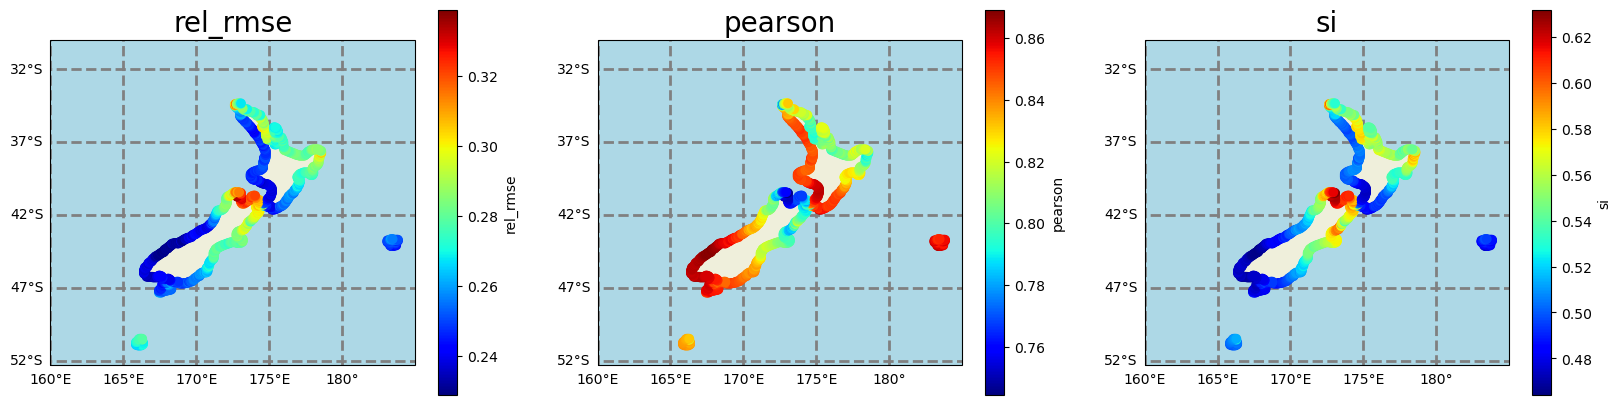

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_regional,plot_stats=['rel_rmse','pearson','si'])

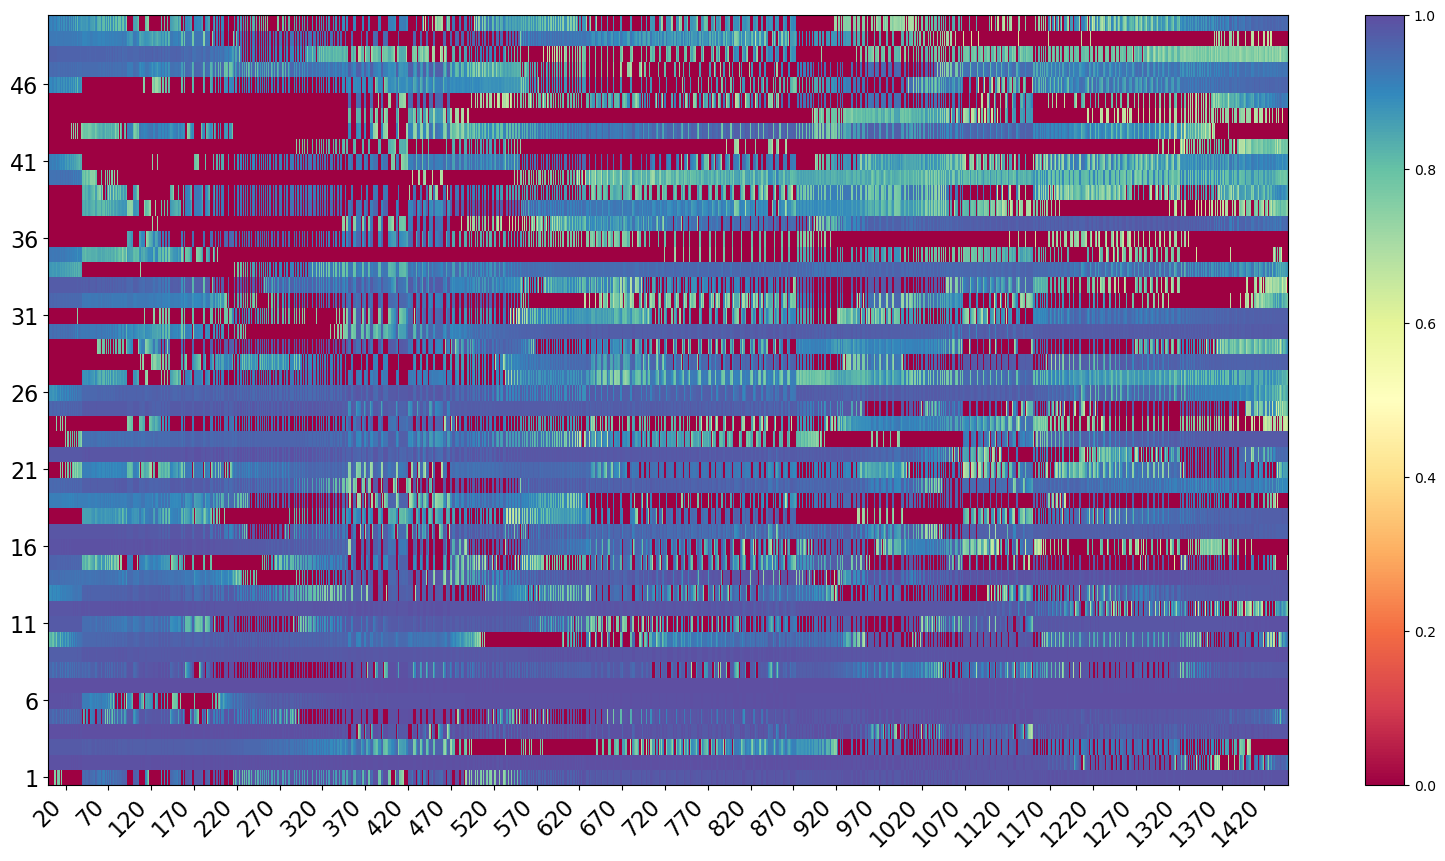

In [6]:
pcs_to_use_regional = np.load(
    data_path+'/statistics/models/pcs_lm_regional_daily.npy',
    allow_pickle=True
)
max_pcs = max([np.max(array) for array in pcs_to_use_regional])
pcs_importance = np.zeros((len(pcs_to_use_regional),max_pcs))
for i,array in enumerate(pcs_to_use_regional):
    for pc in range(max_pcs):
        try:
            pcs_importance[i,pc] = (max_pcs-np.where(array==pc)[0])/max_pcs
        except:
            continue
fig, ax = plt.subplots(figsize=(20,10))
pcol = ax.pcolor(pcs_importance.T[:50,:],cmap='Spectral')
fig.colorbar(pcol)
ax.set_yticks(np.arange(0,50,5)+0.5)
ax.set_yticklabels(np.arange(0,50,5)+1,fontsize=16)
ax.set_xticks(np.arange(20,len(pcs_to_use_regional))[::50]+0.5)
ax.set_xticklabels(np.arange(
    20,len(load_cfsr_moana_uhslc.predictand.site.values),1
)[::50],fontsize=16)
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
plt.show()

```{tip}
Images generated by code, as the one above, can be easily open in a new window with the right click, as they have all been generated with good quality for this particular purpose!!
```

### Linear regression in the UHSLC tidal gauges + validation

Here, we really use for the first time our "validators", which are the main truth in the project. In coastal engineering, we usually use the buoys (if we are working with waves) and the tidal gauges (water elevation) as the real observations, and once they are processed, which is the case of these nodes shown here, they might be used as the data to validate with.

Below, apart from plotting the location of the different tidal gauges that we will be working with, we show how the linear regression with the regional predictor behaves in the nearest locations to the tidal gauges, and how this pre-trained linear regression model performs in that tidal gauge too.

To understand how good or bad the linear model might behave when predicting the storm surge of the tidal guages, we find the answer in the validations we performed in the first notebook, called **Data visualization and validation (data_visualization.ipynb)**, where the comparison of all the tidal gauges and the nearest moana nodes is shown.

```{warning}
This use of the pre-trained linear model with the moana nodes for the tidal gauges must be revised, as the distances between both locations might involve the appearance of new physical phenomena!!
```

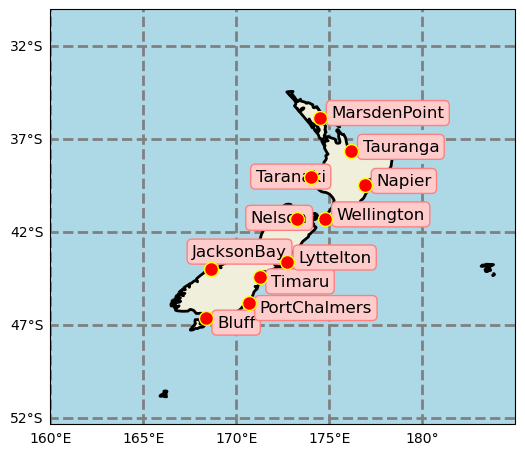

In [7]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 111 PCs : [  6   1   5   3  11   4   8  21   7   0  24  29  25  19 114  15  16  50
  13  14 122 142 119  59  33  99  85  12  37  20  90  54 115  89  42  68
  98 172 111 113  84  48 173  87  96 176 186 208 139  22 261  27  77 121
 174 244  36 110 213  28  71 220  97  57 188 265  39  58 329 130  61   2
  95 330 104 236 296  30 333 323  44 166  38 203  64  26 318  72 385  62
 124  78 109 273 103 189 127  10 233  32 256 135 347  35 117 187 341 129
 282 175  81], 
 will be finally used to train the model!! 



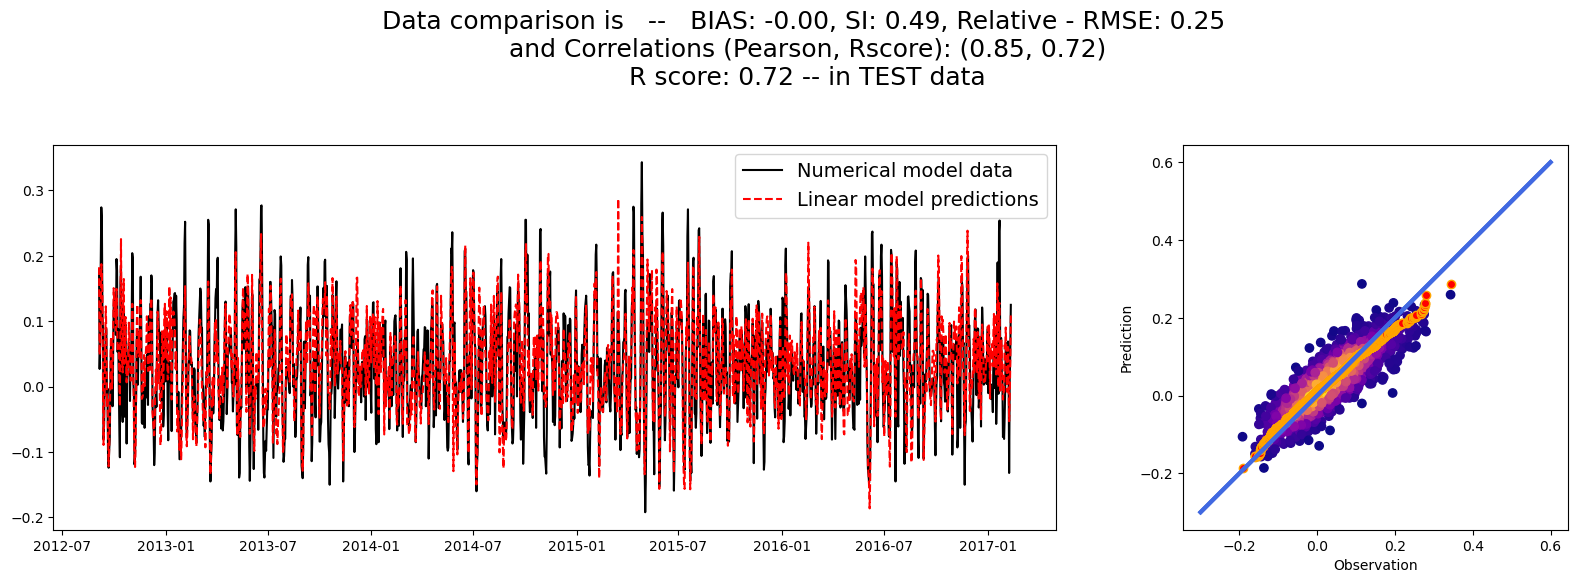

Data comparison is   --   BIAS: -0.00, SI: 0.49, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 R score: 0.72 -- in TEST data


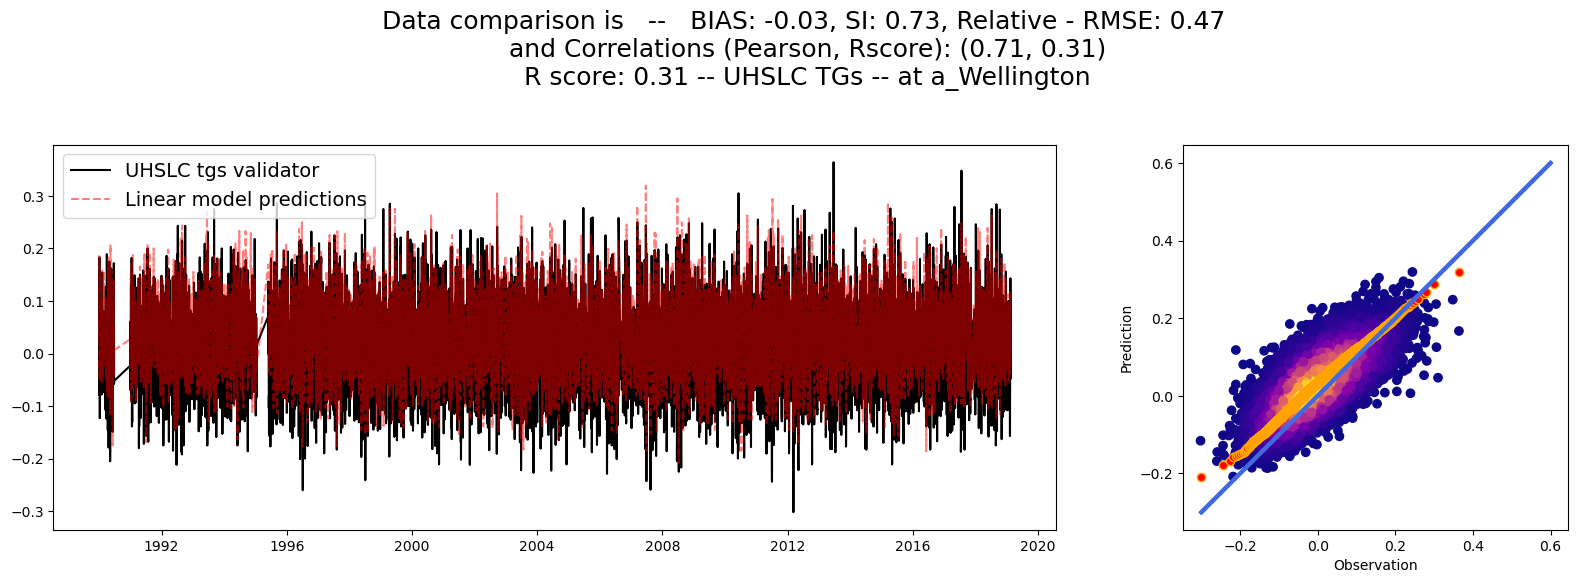


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 99 PCs : [  1   6   4   7   3   5  11   8  28  10  25  12  24   9  22  21  18  14
  50  15  20  81  31  63  67 114 142  85  68 123   2  13  54  16  23  35
  32 220  46  45 278  84 329 256  49  76 113 115  17 170  77   0 261 111
 313 134  58 196  62 157  96 283 249 318 149 166 363  41  19 110 119  47
 122 185  64  59 108 152 188 330  33  69  94 204 181 286  65  57 102 385
 139 173 103 156 209 333  53 143 172], 
 will be finally used to train the model!! 



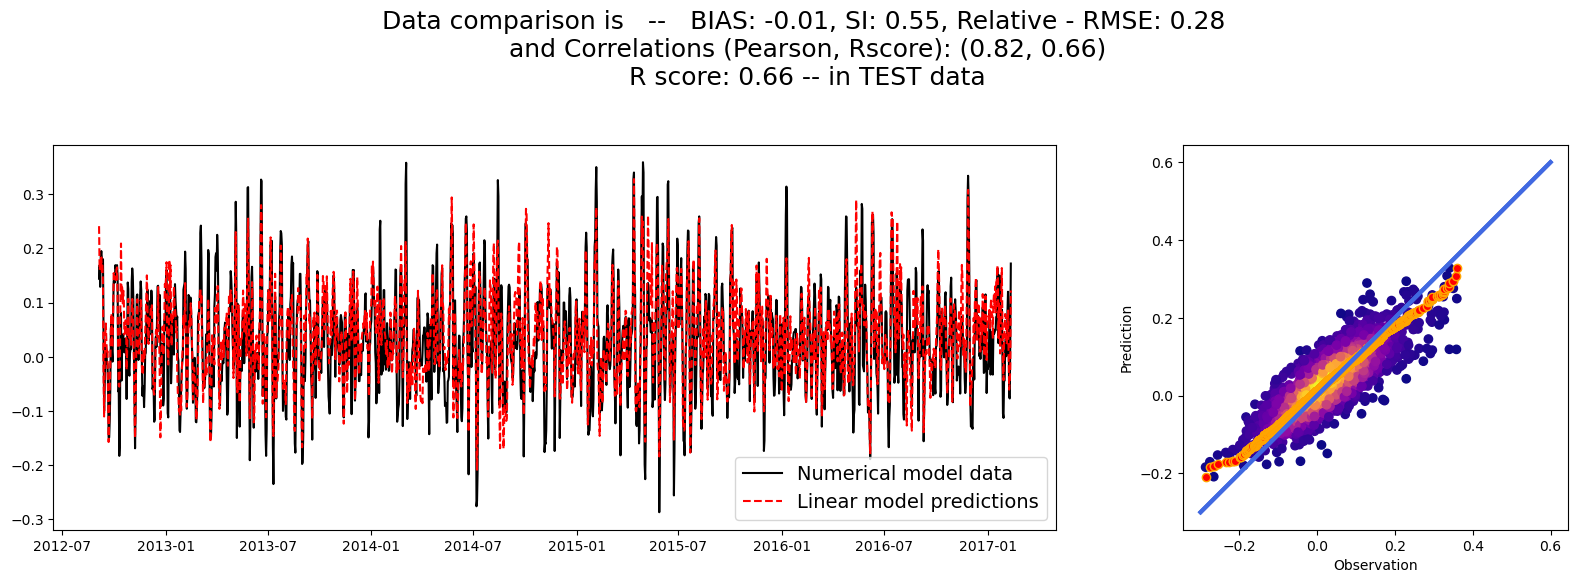

Data comparison is   --   BIAS: -0.01, SI: 0.55, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.66)
 R score: 0.66 -- in TEST data


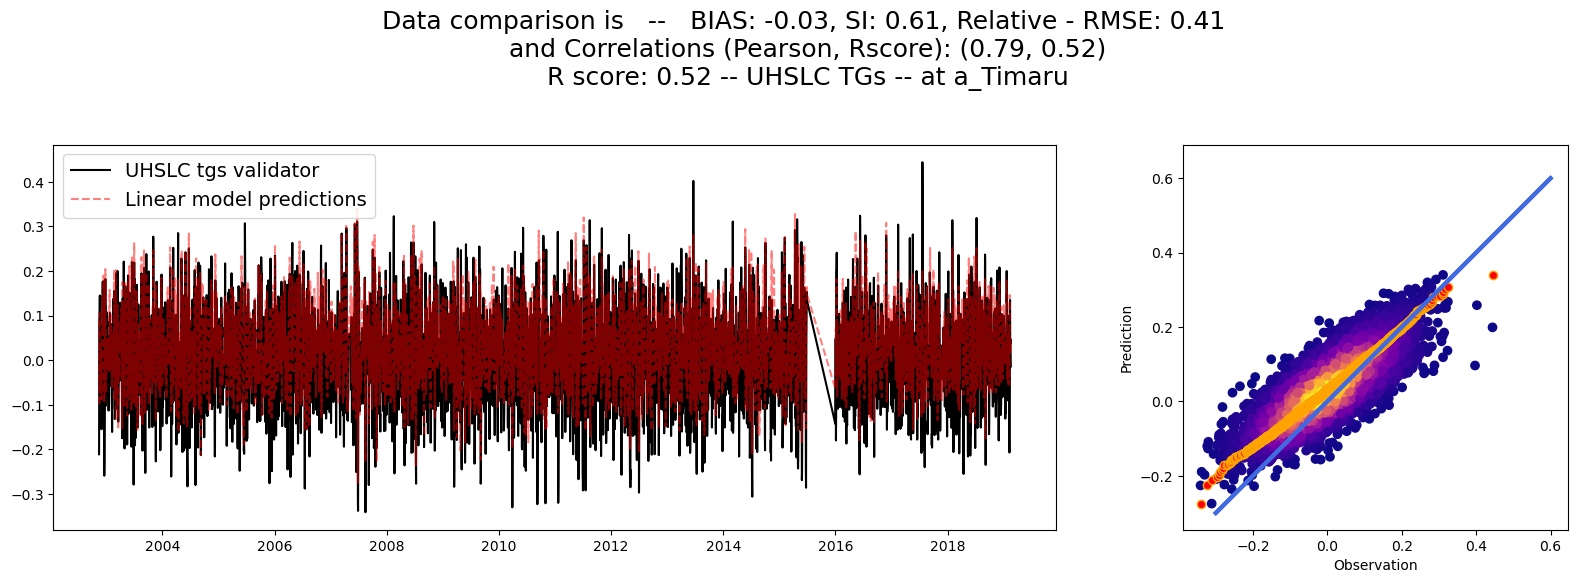


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 116 PCs : [  3   6   1   0   5  11  21   8  24  19  16  15  50 122  59 142  20  37
  25   9  48  10 139  32 172  40  22  33 121  26  38 129 114  46  60  99
  27  14  86  85  90  72 179 176  68  54 213 113  62 235 336 111  87  64
  66 286 119  78  61 273  98  58 379 133 291 181 385  29 216 369 347 265
 237 166 194   2  97 374 218 198 345  67  76 190 127  47 267 257  45   7
 196 115 301 200 145 104 268  42 173 150  18 308 318  88 280 201 323 147
 103  63 143  43 365  53 298 299], 
 will be finally used to train the model!! 



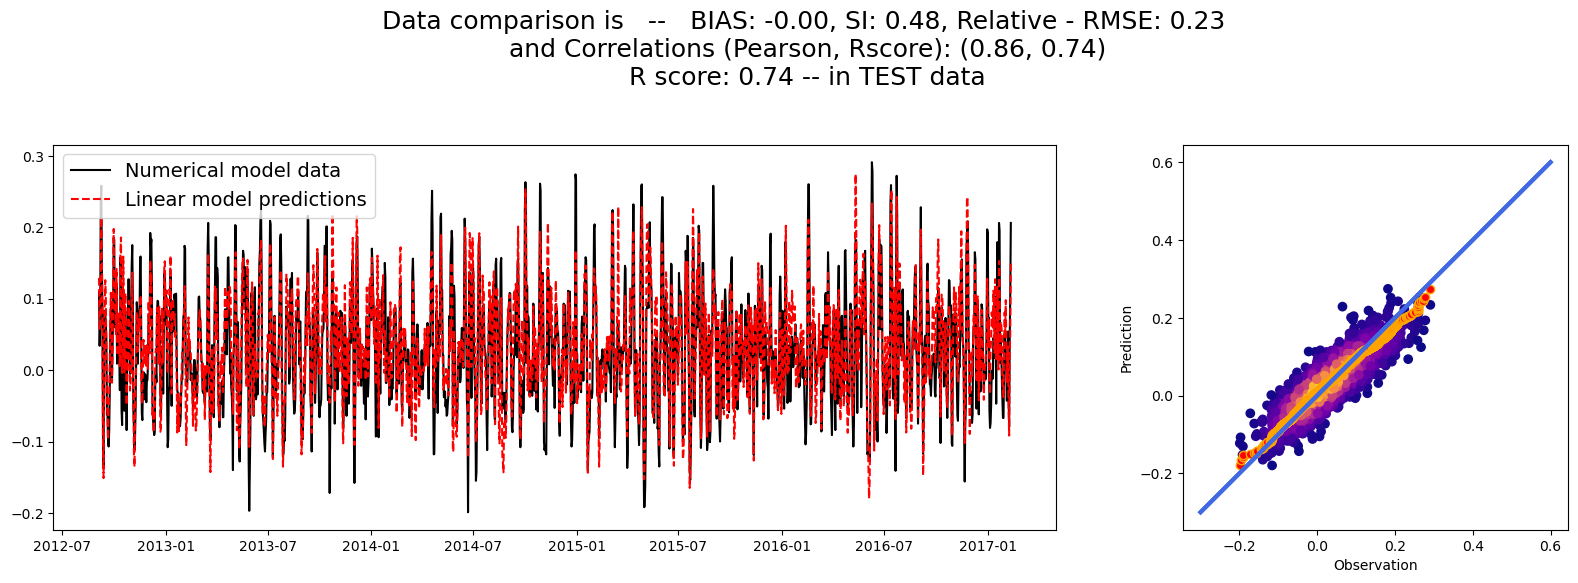

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 R score: 0.74 -- in TEST data


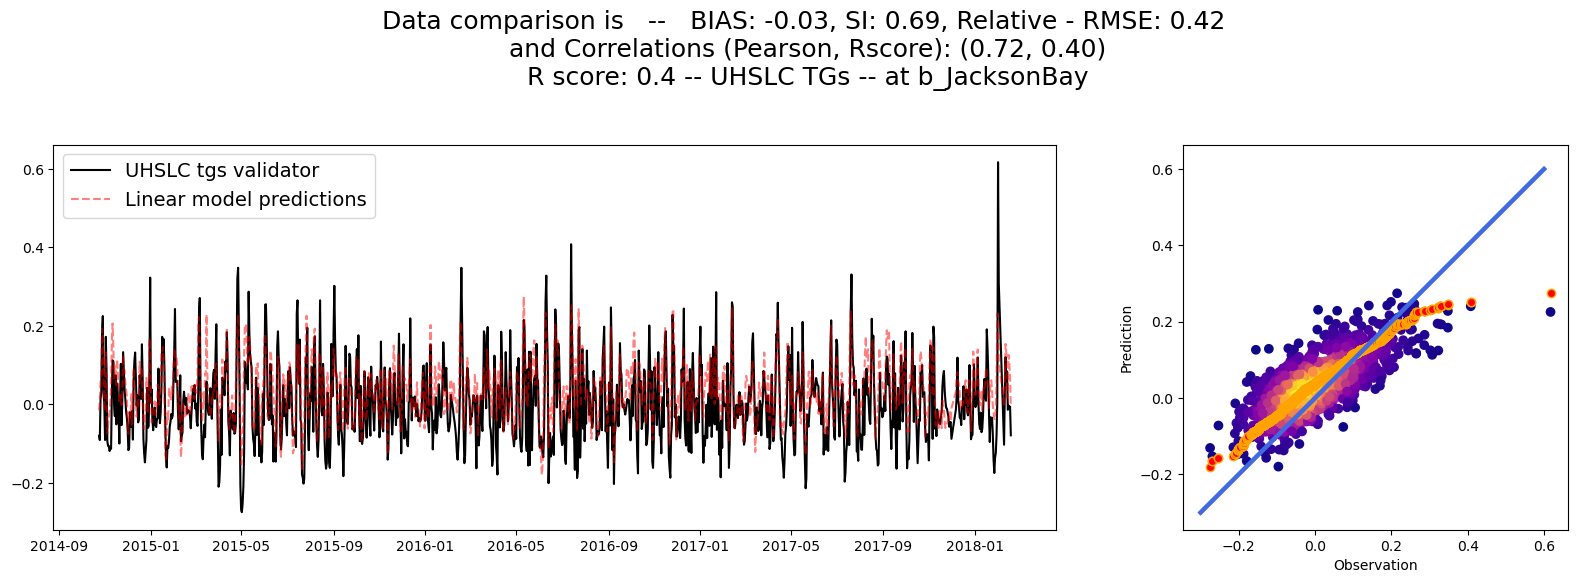


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 156 PCs : [  8   5  13   6  10   0   7  12   4  22   9  27  36  29 115  16  17  30
  93  21  20 191 121  50 223   3  45 225  63 118  69  46 154  65  67  88
   2  58  83  81  51 102  19  60 166  57  11  40  49  38 142 247 310 169
 120 284 367 198  61  75 245  76   1 211 233 281 122 109 369  33  91  25
  94 237  39 106 108  44  90 325 101  99 181 190 147 205 131 144 152 185
  55 385 347 123  26  92 127 112 165 130  54 254  43  37 230  47 212 100
 116 340  35  14 194 379 114 164 365  82 242 332 345 188 286 303 295 298
 374 240 383 282 153 300 159 262 249 248 320  70  73 388 235 259 135 323
  42 138 387 157 250 270 232 161  41 160 314 111], 
 will be finally used to train the model!! 



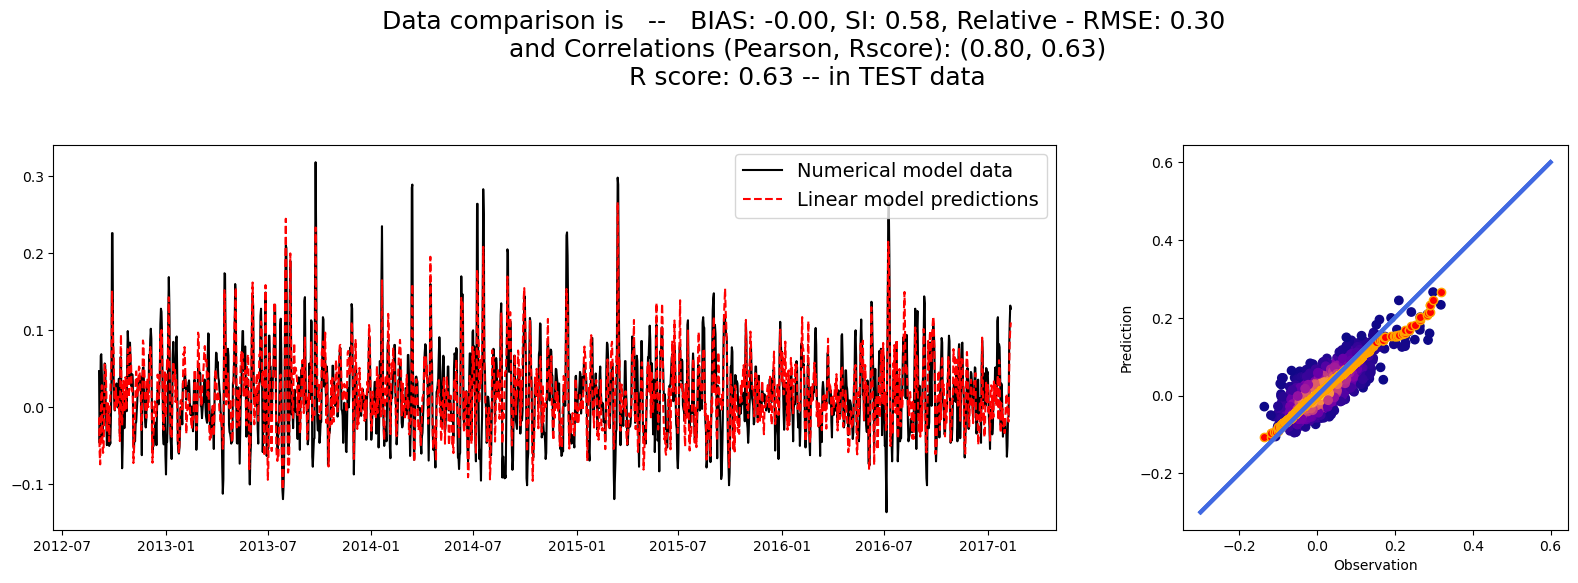

Data comparison is   --   BIAS: -0.00, SI: 0.58, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 R score: 0.63 -- in TEST data


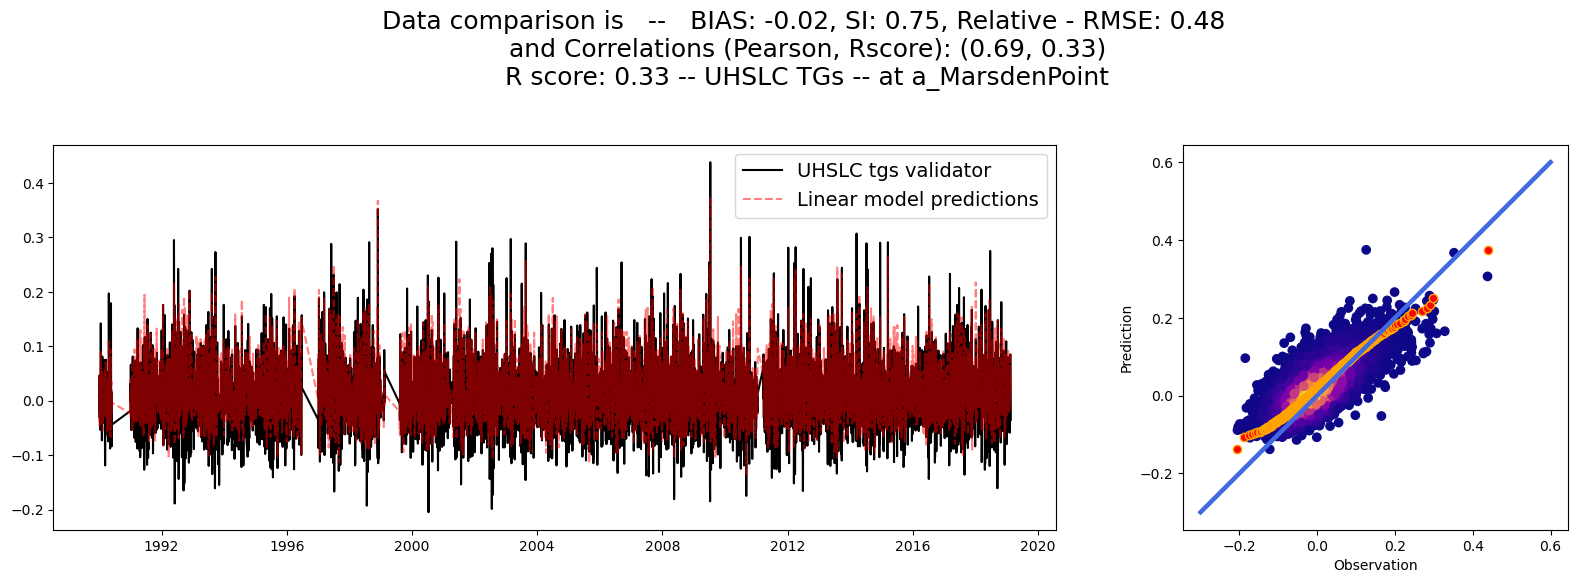


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 116 PCs : [  3   6   1   0   5  11  21   8  24  19  16  15  50 122  59 142  20  37
  25   9  48  10 139  32 172  40  22  33 121  26  38 129 114  46  60  99
  27  14  86  85  90  72 179 176  68  54 213 113  62 235 336 111  87  64
  66 286 119  78  61 273  98  58 379 133 291 181 385  29 216 369 347 265
 237 166 194   2  97 374 218 198 345  67  76 190 127  47 267 257  45   7
 196 115 301 200 145 104 268  42 173 150  18 308 318  88 280 201 323 147
 103  63 143  43 365  53 298 299], 
 will be finally used to train the model!! 



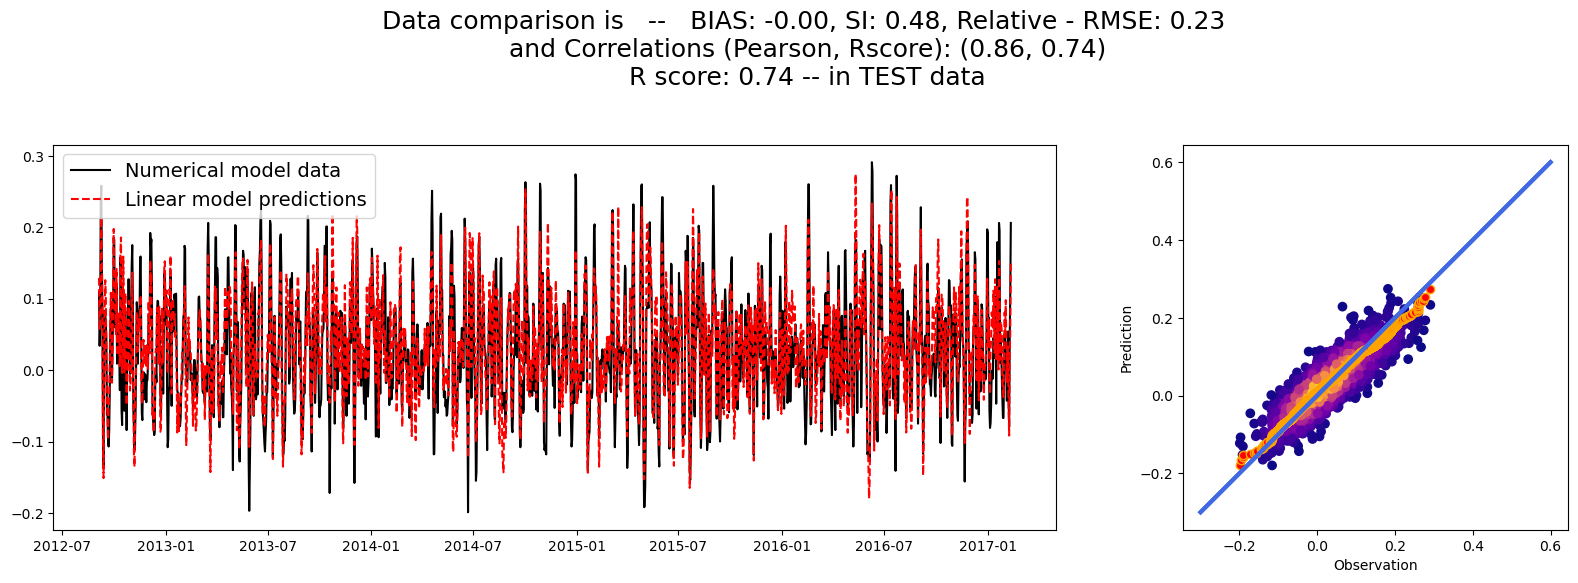

Data comparison is   --   BIAS: -0.00, SI: 0.48, Relative - RMSE: 0.23
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 R score: 0.74 -- in TEST data


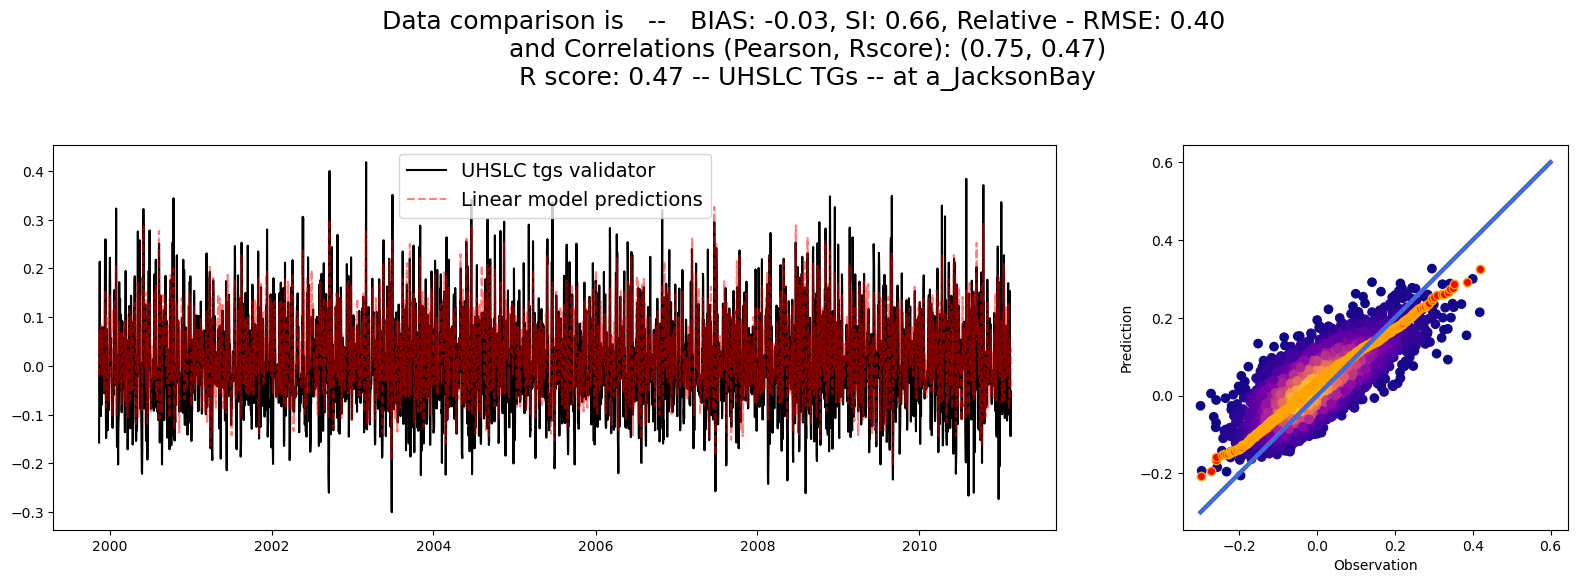


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 117 PCs : [  1   6   4   7   5  11   8  10   3  25  28  24  14  13  22  21  18  12
  31 114  50  20  16  81 142 220  85 329  23  68 278  49 111  46 115  67
  76  32  45 170 181  17  58  54  29   9 261  84 123  96  30  33 113  40
 119 185  63  99  77 110  47 256  41 188  42  35 152 313   2  59  93 196
  64 157 333 318 122 103  57 166 224  86 249  15 106 205 143 364 323  69
 134  56 321 209 262 363 203 159 382 124 251 283 332 156  82 173 174 154
 302 144 107 169 127 109 187 330 244], 
 will be finally used to train the model!! 



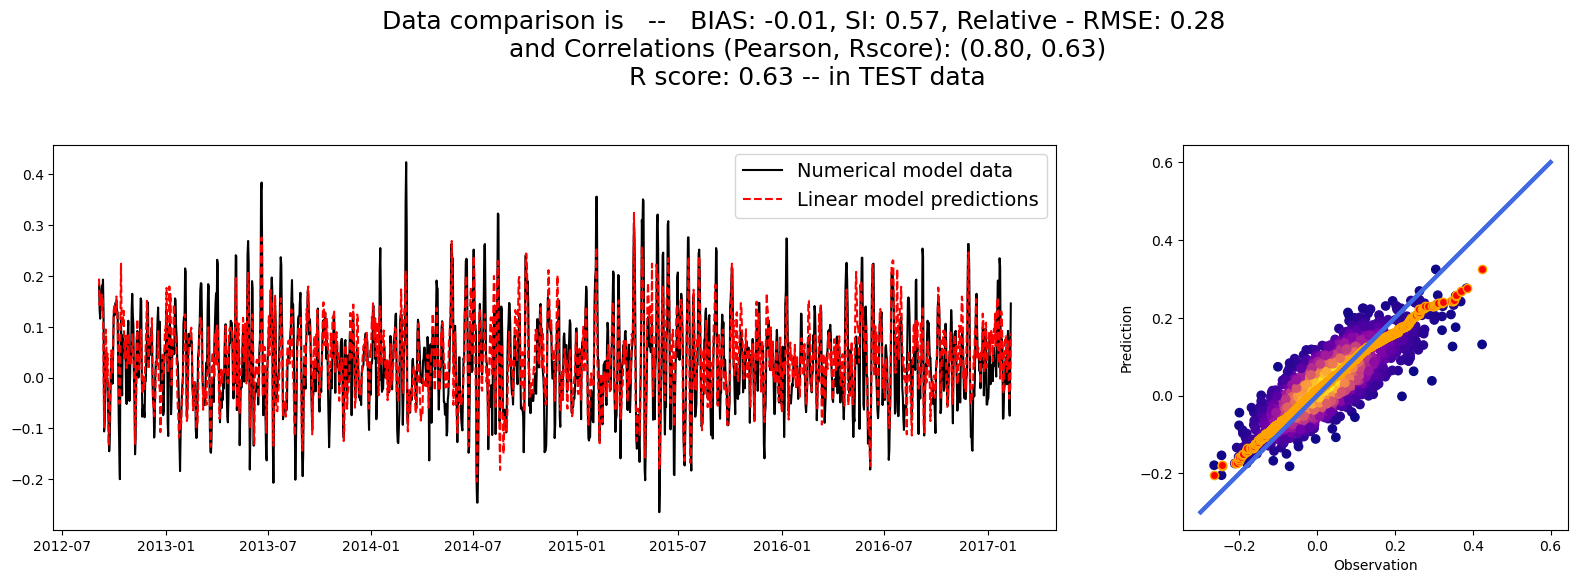

Data comparison is   --   BIAS: -0.01, SI: 0.57, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.63)
 R score: 0.63 -- in TEST data


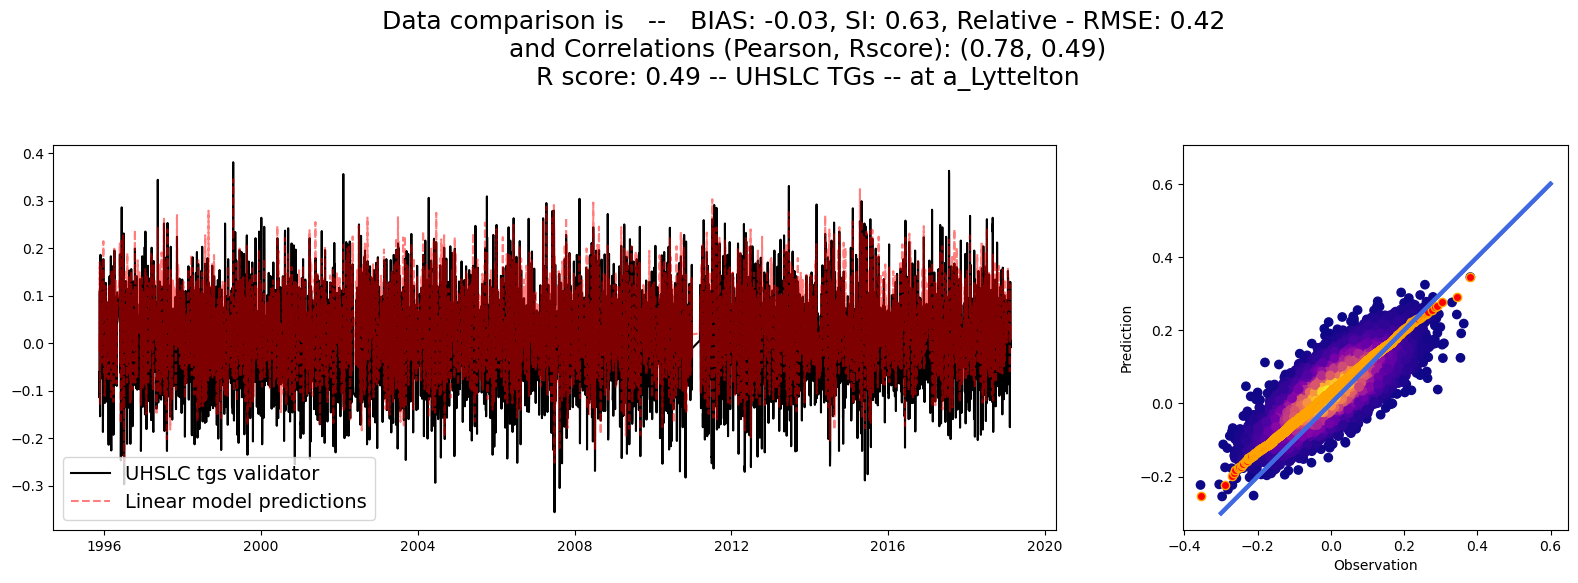


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 118 PCs : [  3   6   5   0   8   1  11  24   4  14  10  16  29  21  19  25 122  50
  18 114  33  45  97  36  61  71  38  13  90  84  15 111  59   7 142 119
  23 166  86  28 121 129 172  85  60  54  68  65  30  89  37  72  42 318
 110 273  98 261 208  40 285  55 379  64  48  39 148  62 139 101 344  92
 108 193  87 374 213 186  26 113  95 124 216 383  43 334 322 107 197 376
 308 127 206 311 203 112  74 220 117 169 268 329  20 211 337  99 331  31
 330  76  78 187  49 118 296 174 347 251], 
 will be finally used to train the model!! 



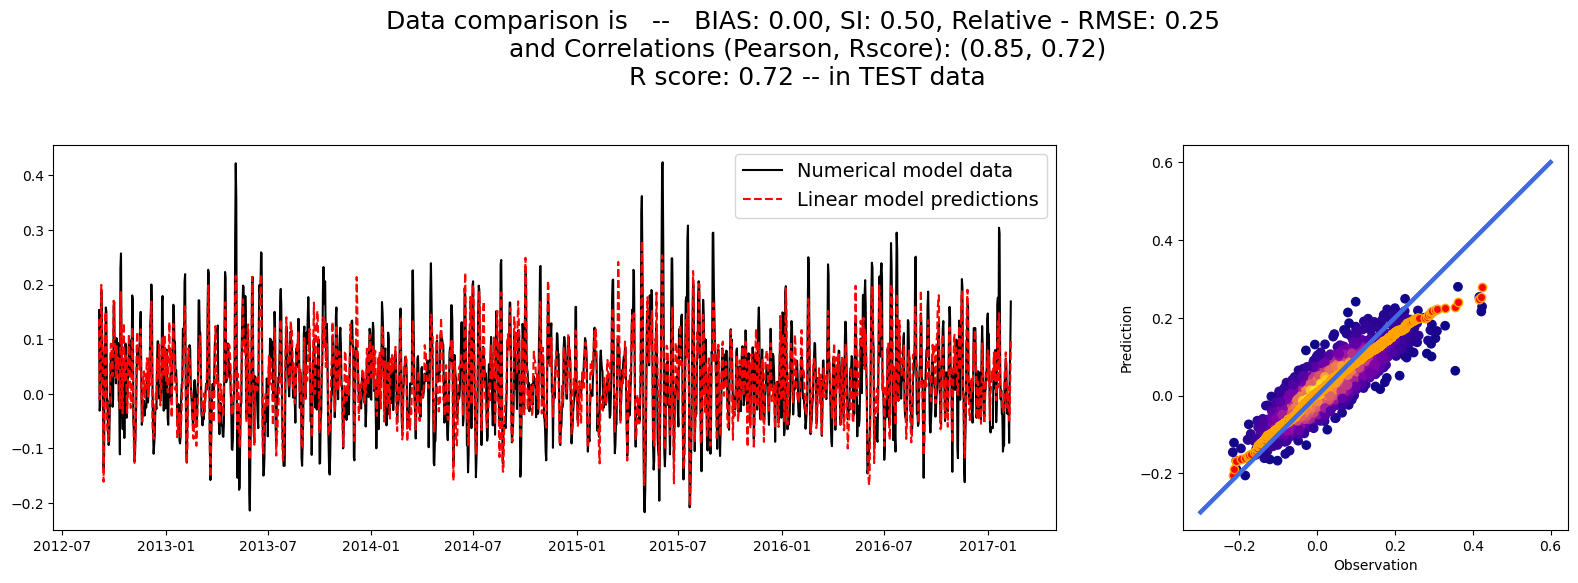

Data comparison is   --   BIAS: 0.00, SI: 0.50, Relative - RMSE: 0.25
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 R score: 0.72 -- in TEST data


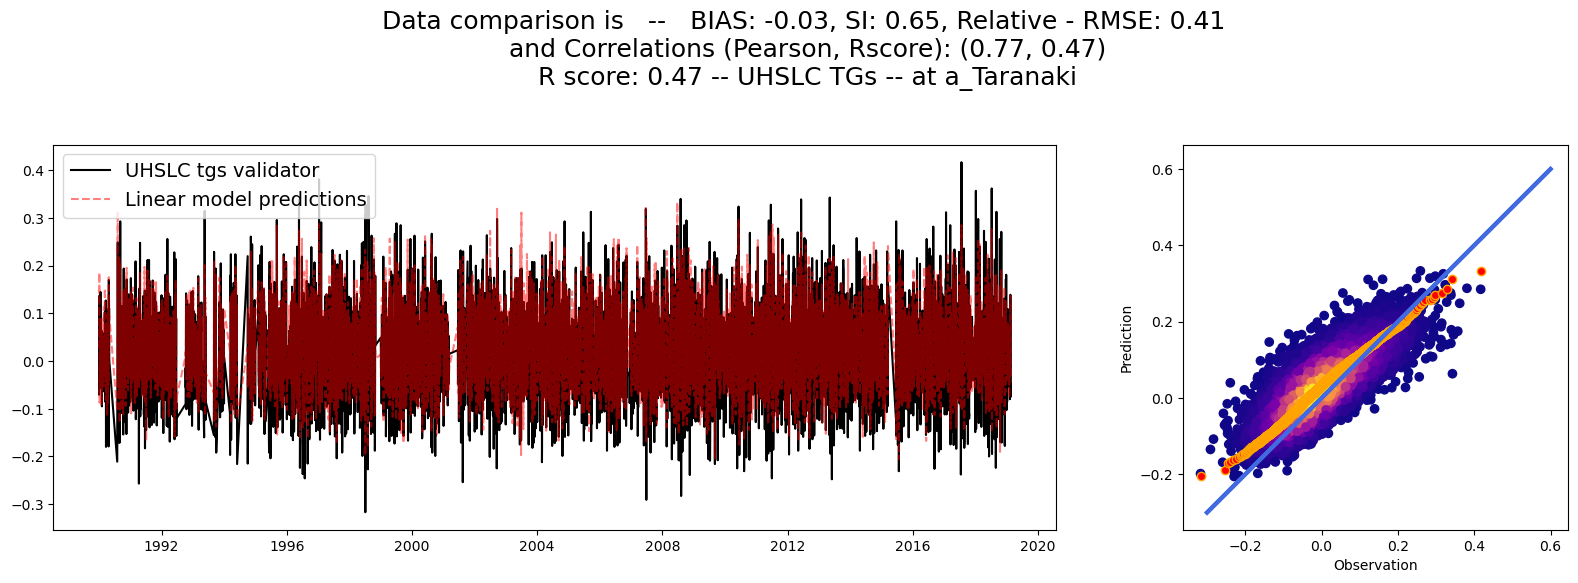


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 109 PCs : [  6   3   1  15  11  21  16   7   8  24   4   2  12  19  47   9  25  32
  50  67  22  72 142  13  59 139 104  46  10  31 150  42  17 122 157  18
 286  98  65  71 115  53 172  99 176  29  14  48 280 211  34 173 231   5
 281 289 130 385 201 113 228  68 103 174 120   0 133  91  20 300 164 257
  94  76 351 283 129 101 302  78  37 136  89 169 188 215  28 247  62 323
 179 154  58  49 220  51  82  35 160 237 112 326 363  64 205 288 178 367
  26], 
 will be finally used to train the model!! 



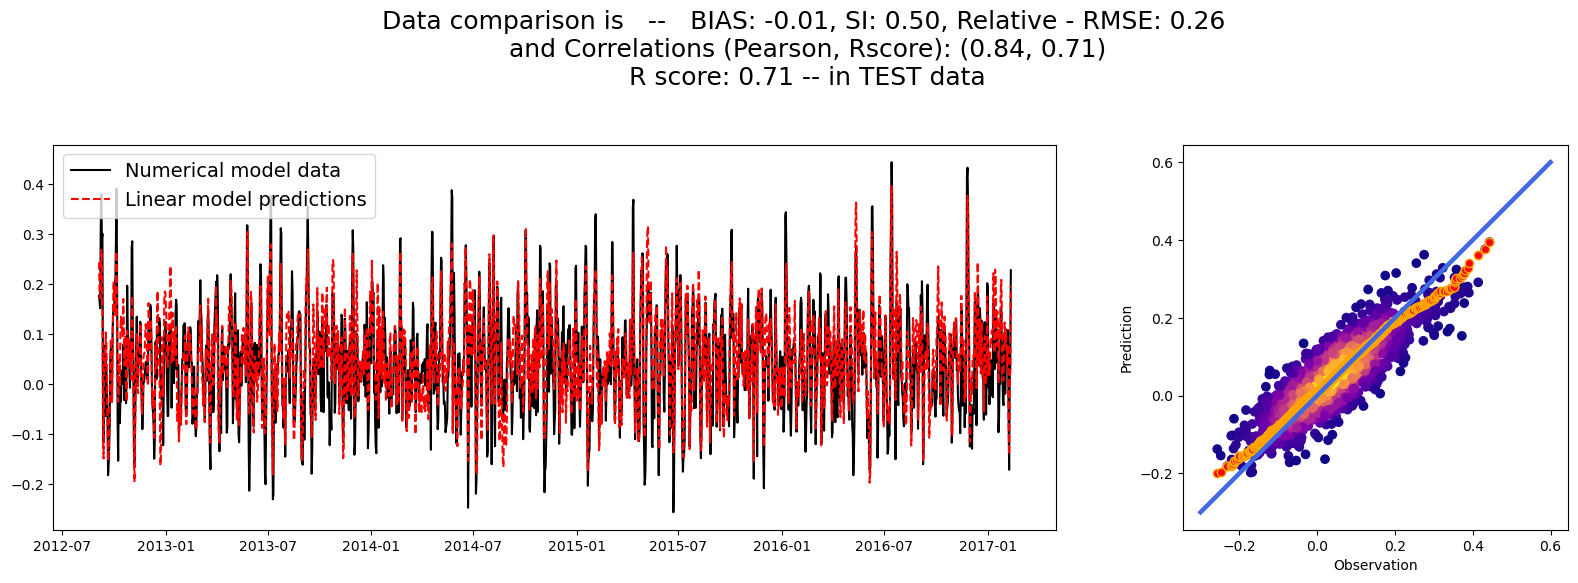

Data comparison is   --   BIAS: -0.01, SI: 0.50, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.71)
 R score: 0.71 -- in TEST data


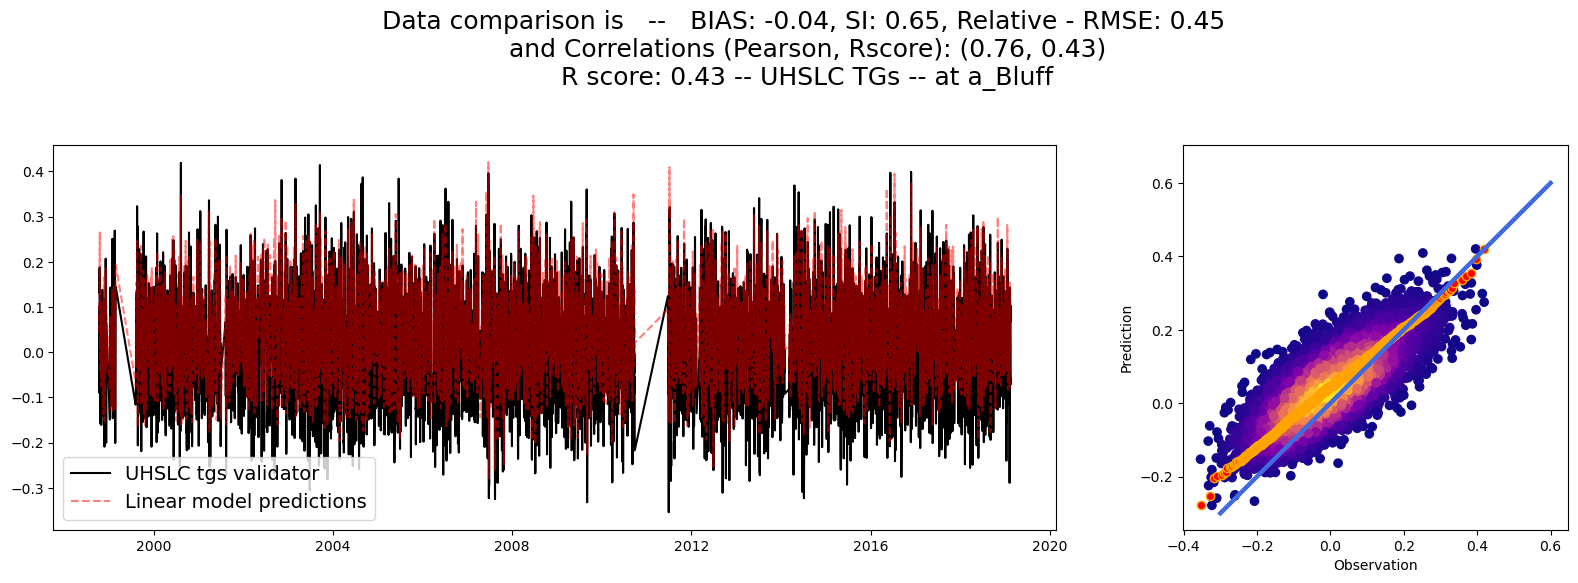


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 100 PCs : [  6   1   3   7   4  11   8  15  21   9  12  25  10  24  28   2  50   5
  22  18  19  67 142  35  63 104  72  76 157 115  23 139  54  20 286 114
 113  45  58 283  30  94 220 256  81  16 172 123 134 173  59  77  65 122
 150  46 130  68 363 129 278 280  62 231  71 174 289 385 257 176 179 235
  85 108 149 204 201 237 147 313  98  89   0 170 281  99  53  86 228 300
  13 103 329  79 137 244  47 240  61 169], 
 will be finally used to train the model!! 



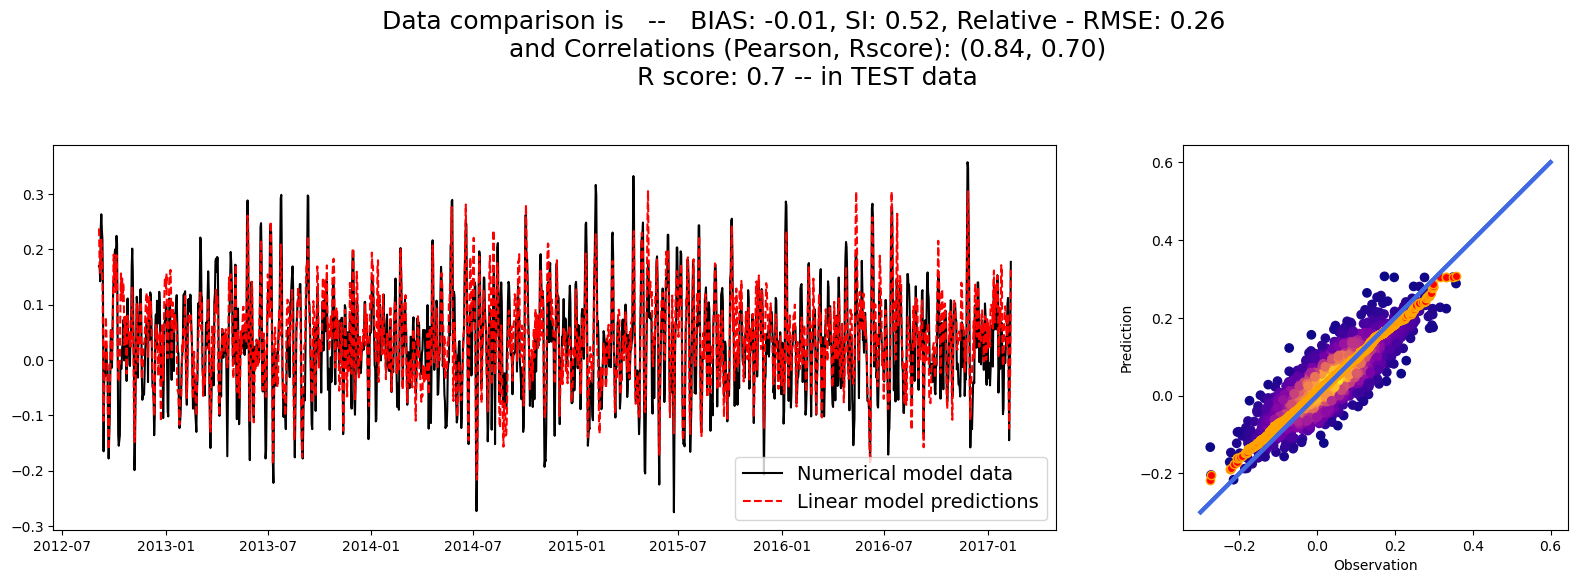

Data comparison is   --   BIAS: -0.01, SI: 0.52, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.84, 0.70)
 R score: 0.7 -- in TEST data


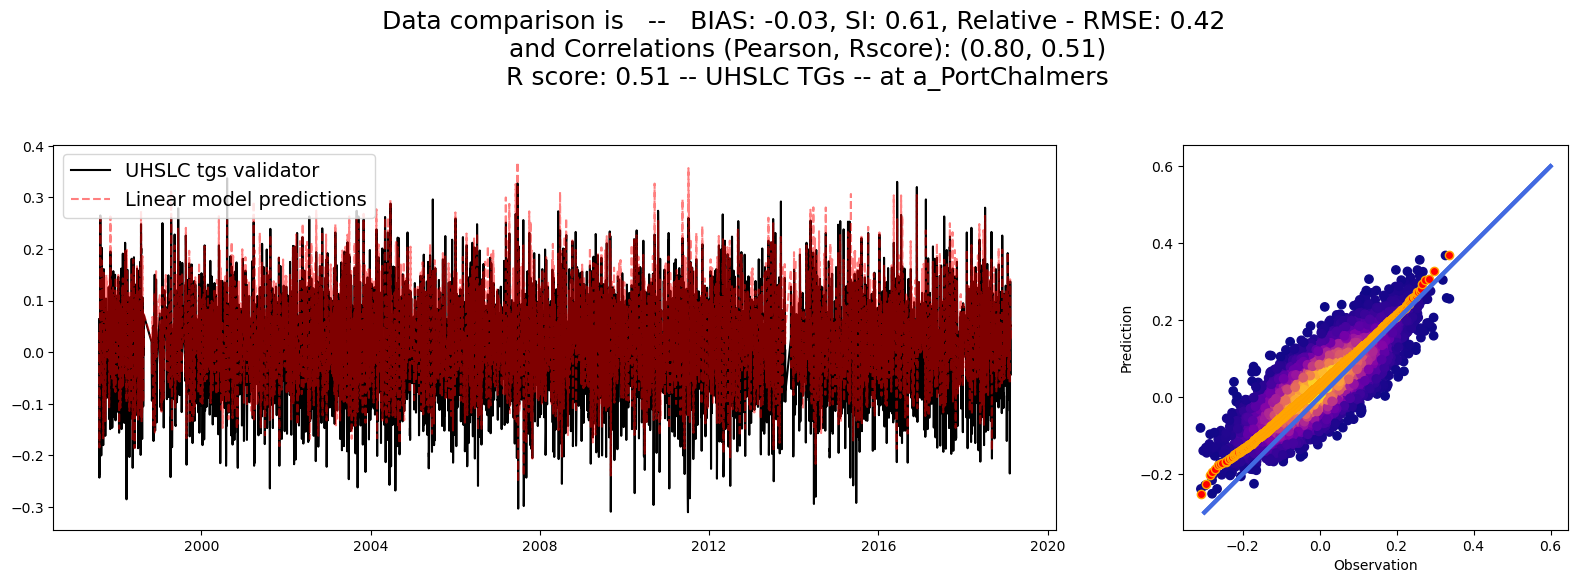


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 143 PCs : [  6   5   8  13   4   0   1  10  27  29  36   7   9  16   3  25   2  22
  11  50  19  33  65  42  93  26 169 154 121 223  63 122  46 102 115 118
  58  88 127  81 225  17 119  85  61  30  83 323 143 164 106 248  67 114
 191  57  40 194  12 211  69 165 228  32  75  60 310  47 166  68  51  39
  34 144 379 198 372 181 175  20  98  45 245 112  96 149 216 233  76 369
  23 286 159 142  87 261 213  91 383 124 285  62 385 296 215 298 387 230
 212 320  49  84 105 117 363  95  70 351 120 157 234 249 268 314 221 184
 264  53 350 100  55  56 247  38  37 176 240 187 265 137 345 237 219], 
 will be finally used to train the model!! 



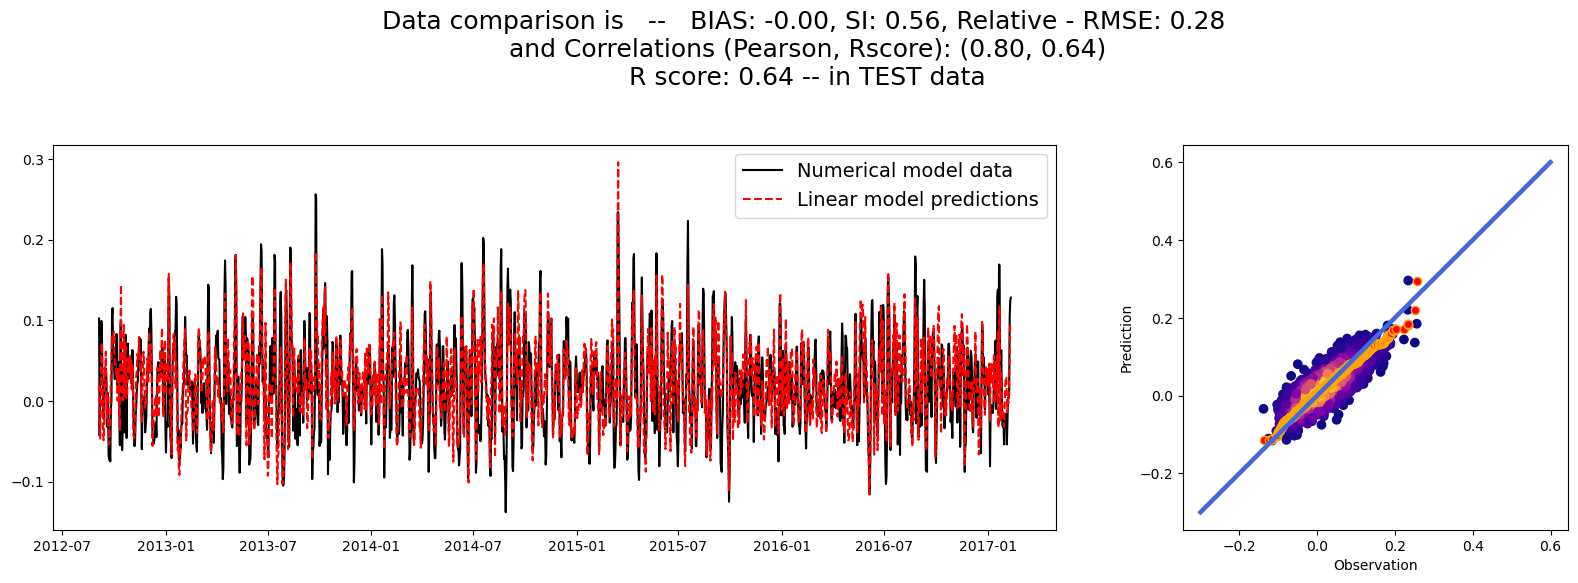

Data comparison is   --   BIAS: -0.00, SI: 0.56, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.80, 0.64)
 R score: 0.64 -- in TEST data


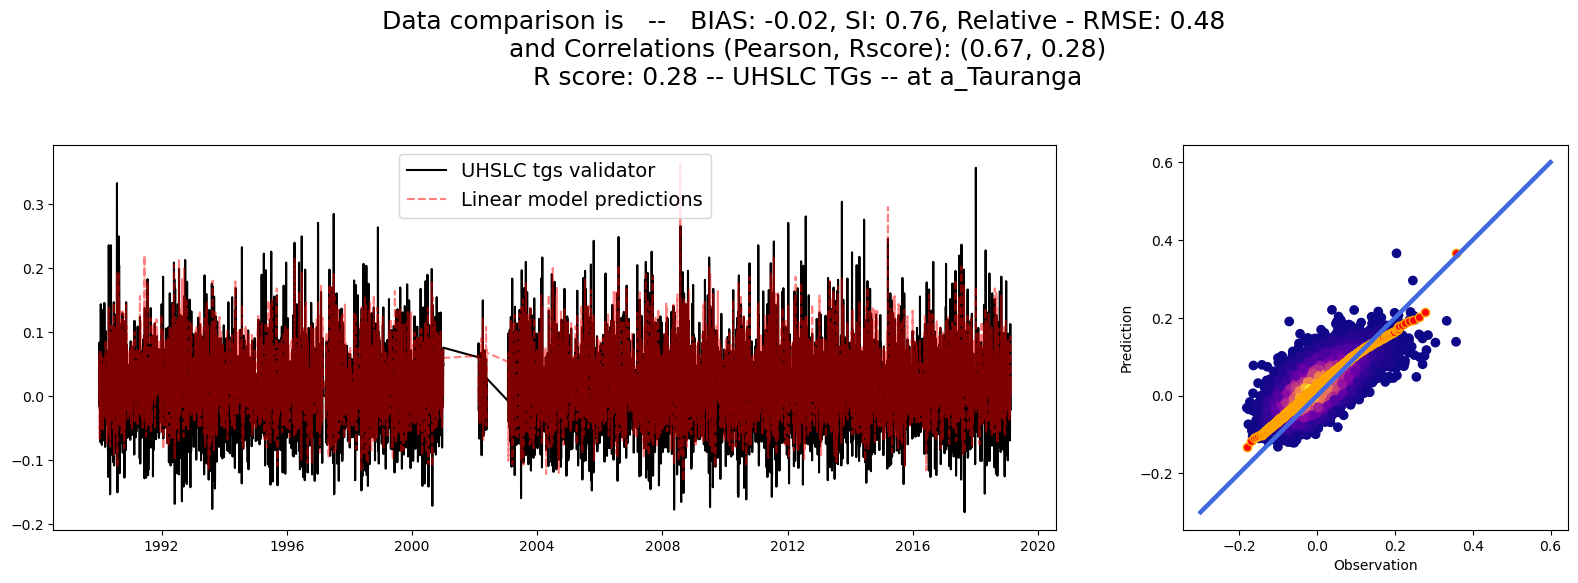


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 109 PCs : [  1   5   6   4   8  13  11   0  25  29   9  42  36  32  21  33   3 114
   7 119 124  85  27   2  19  46  50 169  44  31 164  12  65 175  68 127
  16  28 261  99  77 137  98 323  23 154 198 106 213 122 144  96 149  56
 113  34  39 158  62  37 150  83  89 171 173  59  26 314 107 351 101 138
 143  60 350 223 118  43 203 372 108 172  75  94 333 342  93 296 174  47
  38  20  24 298 327  57 216 244 159 165 186 379  54 105  14  40 103 315
  87], 
 will be finally used to train the model!! 



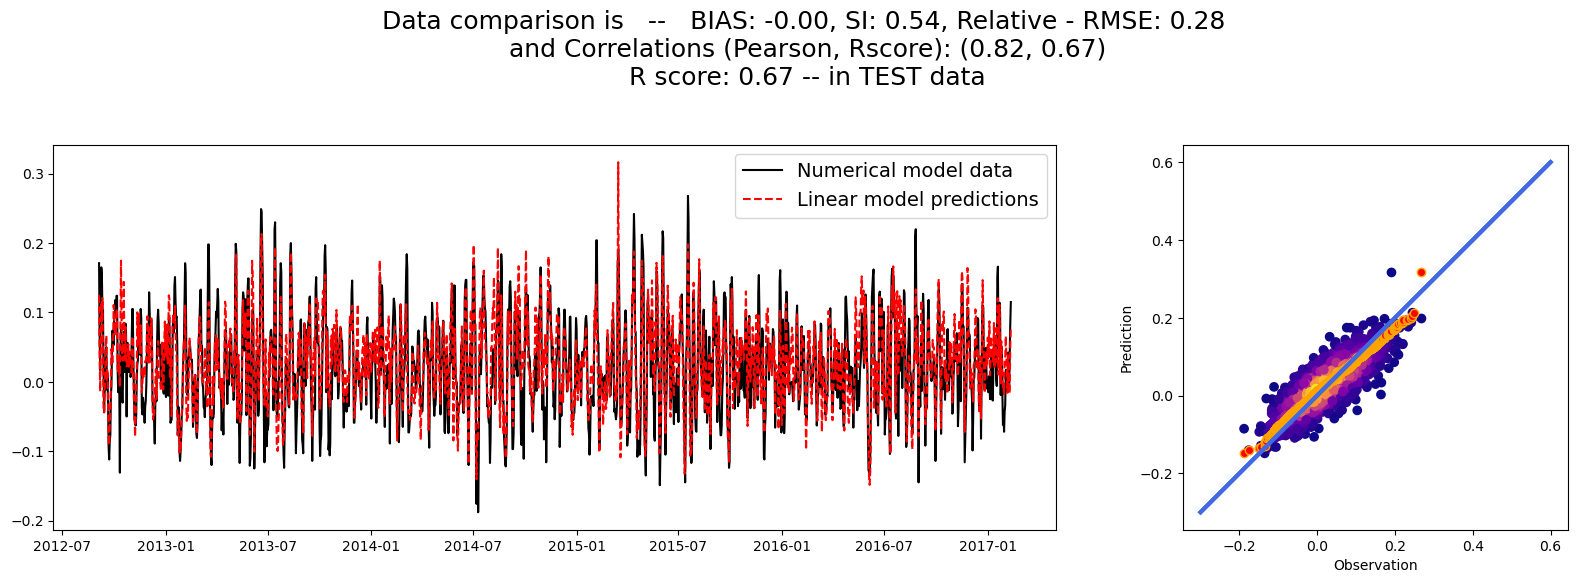

Data comparison is   --   BIAS: -0.00, SI: 0.54, Relative - RMSE: 0.28
 and Correlations (Pearson, Rscore): (0.82, 0.67)
 R score: 0.67 -- in TEST data


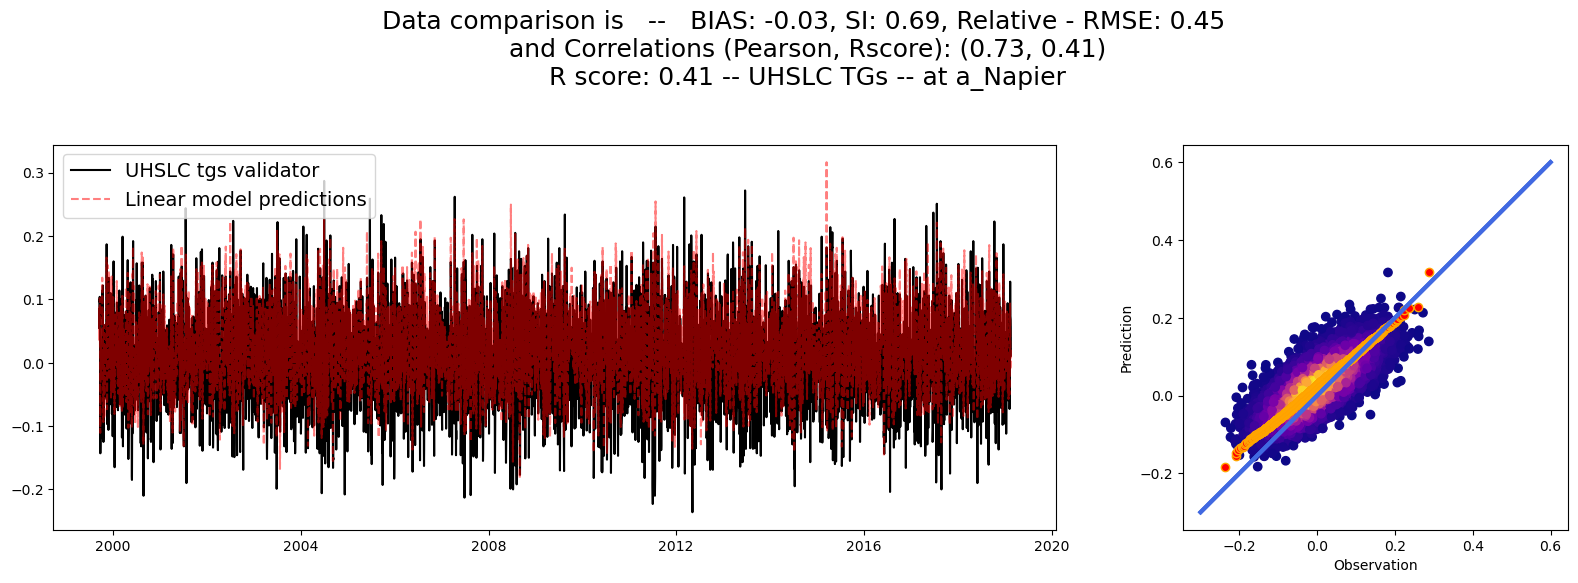


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 112 PCs : [  6   1   5   8  13  11   3   0   4  21  24  29  19  50 114  27  42  25
  17  33 119  16  85  20 122 127  99 169  36  26  64  54 213  65 261  59
  96 142   9 124  40 128 172  37 121  48 323  68  49  12  22  97  90  77
 273 379 173  58 196 381  32 164 255   2 318 175 296 176 203 129 137  62
 223 148 177  51 266  47 151 268  57 369 216 170 113 156 185 333 106 102
 105 241 187  86 111  31 256 365 235  93 109 244 312 330 166 316  39  80
 372 125  76 162], 
 will be finally used to train the model!! 



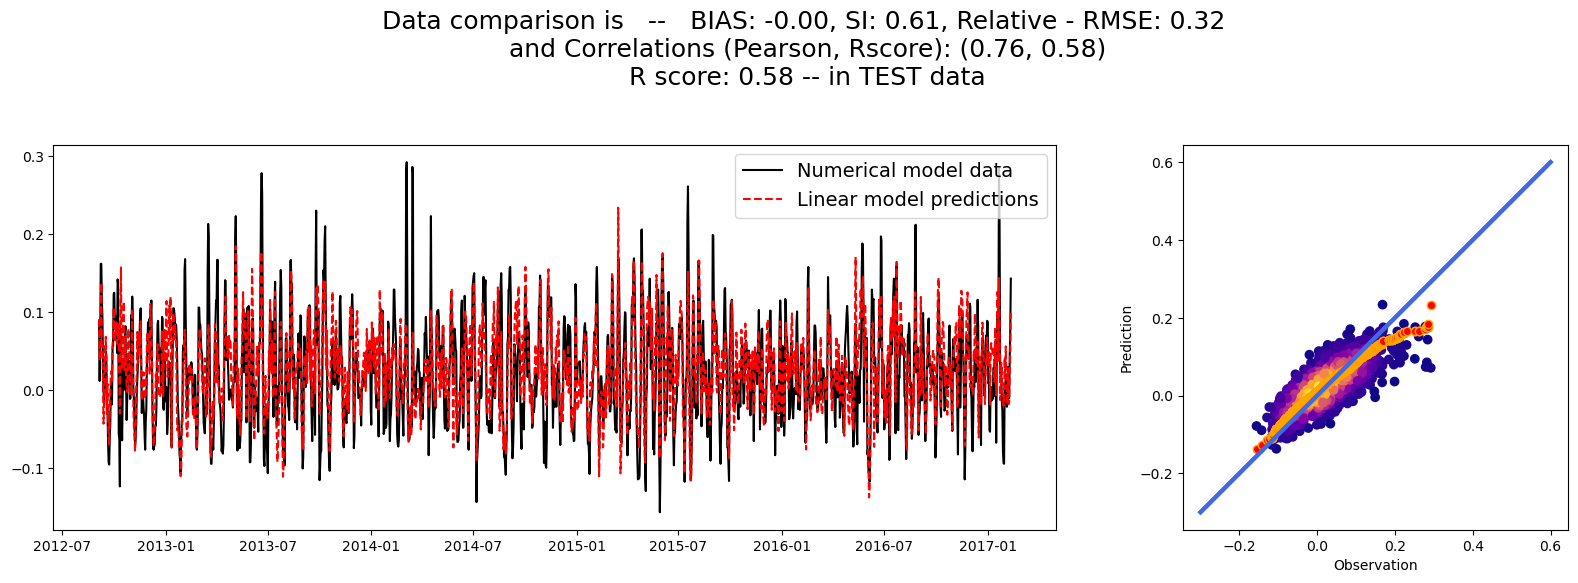

Data comparison is   --   BIAS: -0.00, SI: 0.61, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.58)
 R score: 0.58 -- in TEST data


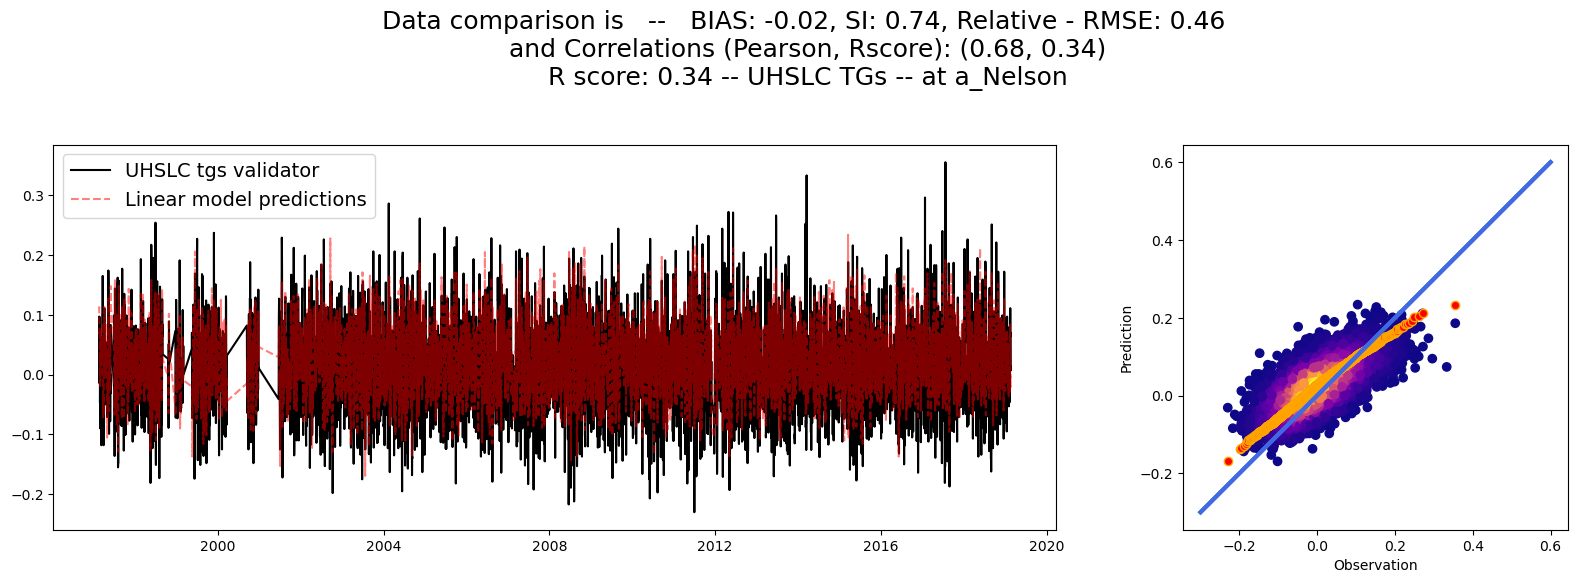

In [8]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat, model, pcs_to_use = MultiLinear_Regression(
        pcs_cfsr, ss_moana, plot_results=True, verbose=True,
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        )
    )

### Linear regression - Ana's paper

In the following two cells, we do the regional-linear regression again, but this time we train the model with the tidal guages directly, just to see how our predictors are behaving when compared to results in previous works, as the one available at Rueda et al. 2018:

```{figure} ../media/images/anaetal.png
---
width: 700px
name: anaetal
---
Result from Rueda et al. and some more private tidal guages locations. Full paper available ([here](https://www.researchgate.net/publication/328587769_Marine_climate_variability_based_on_weather_patterns_for_a_complicated_island_setting_The_New_Zealand_case))
```


 loading and plotting the private tidal guages... 


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 109 PCs : [  1   6   3   5  21  11   0   7   8  10  15  24  25  64  19 172 252  29
  14  85 114  33 107 122  37  13  26 330 159  16 174 329  78  68 115  55
   2 309 111  90 201 125 116   4 112 246  99  42 134 101  28 142 118 337
 321 317 108 120 119 157  96 386 176  38 334 310  58 129 374 338 335  50
 139 347 187  59 153 226  89 336  84  98  47  72 161 208 204   9  81 136
  18 344 205  95 106 185 269 178 352 257 387 103  65 368 123 209 359 248
 164], 
 will be finally used to train the model!! 



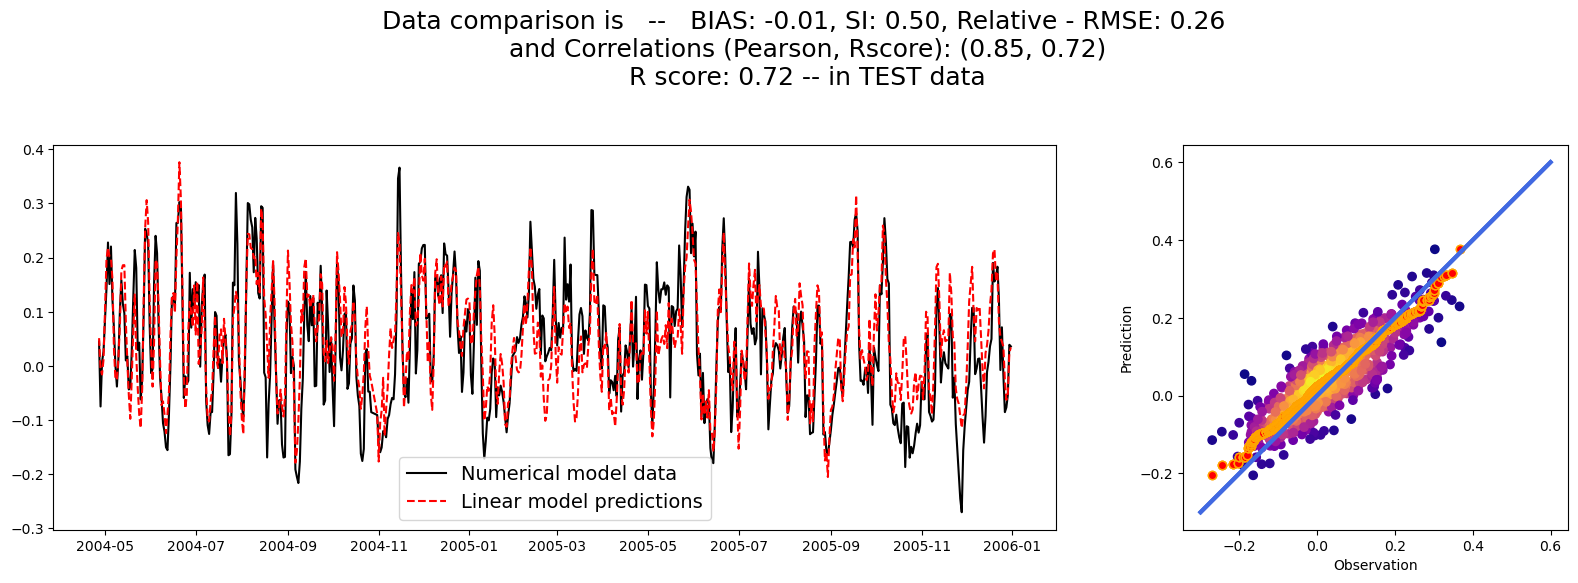

Data comparison is   --   BIAS: -0.01, SI: 0.50, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 R score: 0.72 -- in TEST data


 -- METRICS -- 

 {'bias': -0.010944688103278769, 'si': 0.5007030217432502, 'rmse': 0.06200302620280216, 'rel_rmse': 0.25989866757575514, 'pearson': 0.8512398789054239, 'rscore': 0.7156399005866414, 'ext_rmse': 0.06381855397126245, 'ext_pearson': 0.4772185192798654} 

 obtained with LinearRegression(normalize=True) !!


In [9]:
# linear regression in kapiti island
ss_kapiti = load_private_tgs().sel(name='Kapiti_Is').resample(time='1D').max()
stats_kapiti, lm_kapiti, pcs_to_use_kapiti = MultiLinear_Regression(
    pcs_cfsr, ss_kapiti, plot_results=True, verbose=True
)
print(f'\n\n -- METRICS -- \n\n {stats_kapiti} \n\n obtained with {lm_kapiti} !!')

In [10]:
from sscode.utils import calculate_relative_winds
kapiti_wind = calculate_relative_winds(
    location=(174.9,-40.84), # kapiti location
    uw=load_cfsr_moana_uhslc.predictor_wind.U_GRD_L103,
    vw=load_cfsr_moana_uhslc.predictor_wind.V_GRD_L103
) # kapiti_wind


 calculating winds with: 

 <xarray.Dataset>
Dimensions:         (lat: 160, lon: 161, time: 11444)
Coordinates:
  * time            (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2021-05-01
  * lat             (lat) float32 -20.14 -20.45 -20.76 ... -69.16 -69.47 -69.78
  * lon             (lon) float32 140.0 140.3 140.6 140.9 ... 189.4 189.7 190.0
Data variables:
    U_GRD_L103      (time, lat, lon) float32 -2.324 -2.207 -2.308 ... 2.449 nan
    V_GRD_L103      (time, lat, lon) float32 -0.9279 -1.071 -1.217 ... 3.73 nan
    uw2             (time, lat, lon) float32 5.402 4.869 5.328 ... 5.997 nan
    vw2             (time, lat, lon) float32 0.861 1.146 1.481 ... 13.91 nan
    wind_magnitude  (time, lat, lon) float32 2.503 2.453 2.61 ... 4.462 nan 




 lets calculate the PCs... 


 adding the wind to the predictor... 


 winds predictor with shape: 
 (11354, 45, 51) 


 calculating PCs matrix with shape: 
 (11353, 4590) 


 plotting 2 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



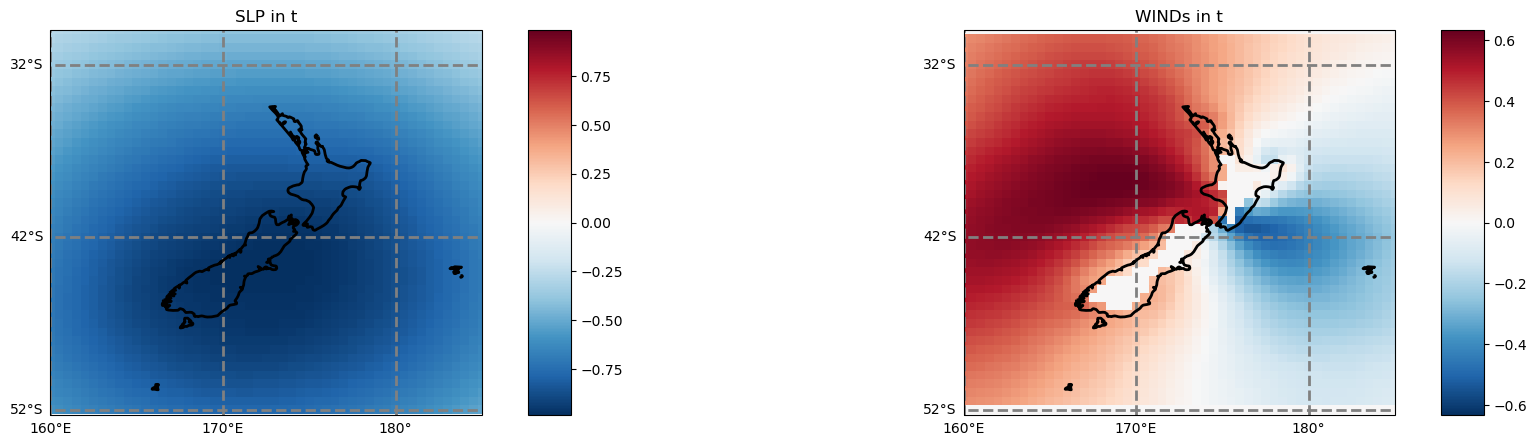

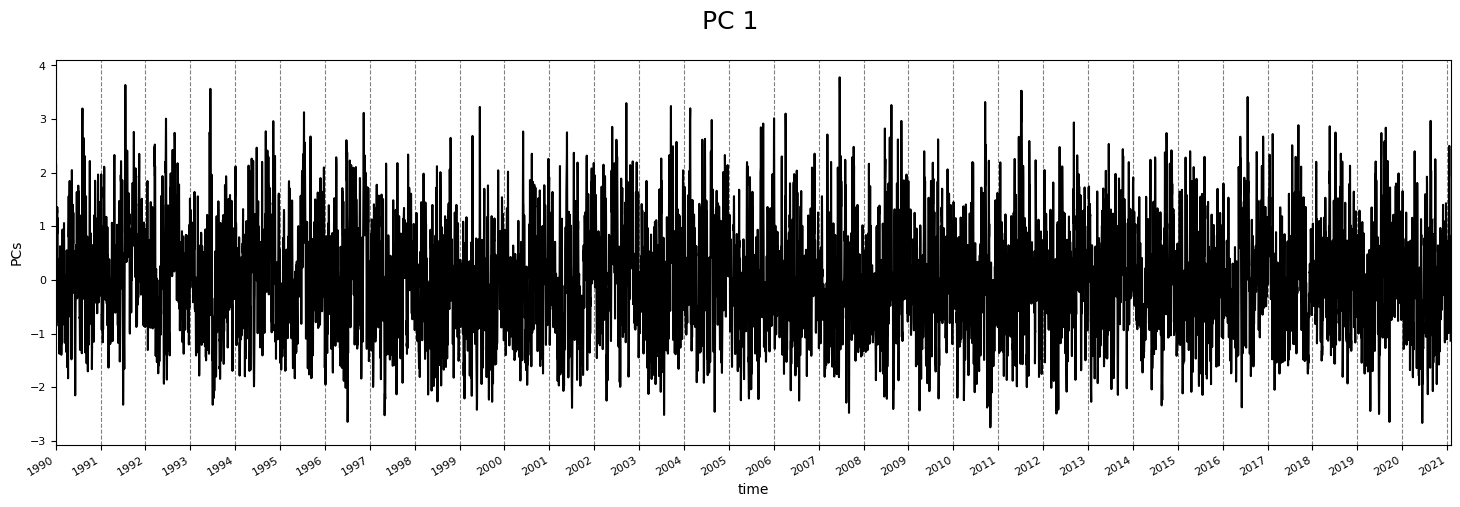

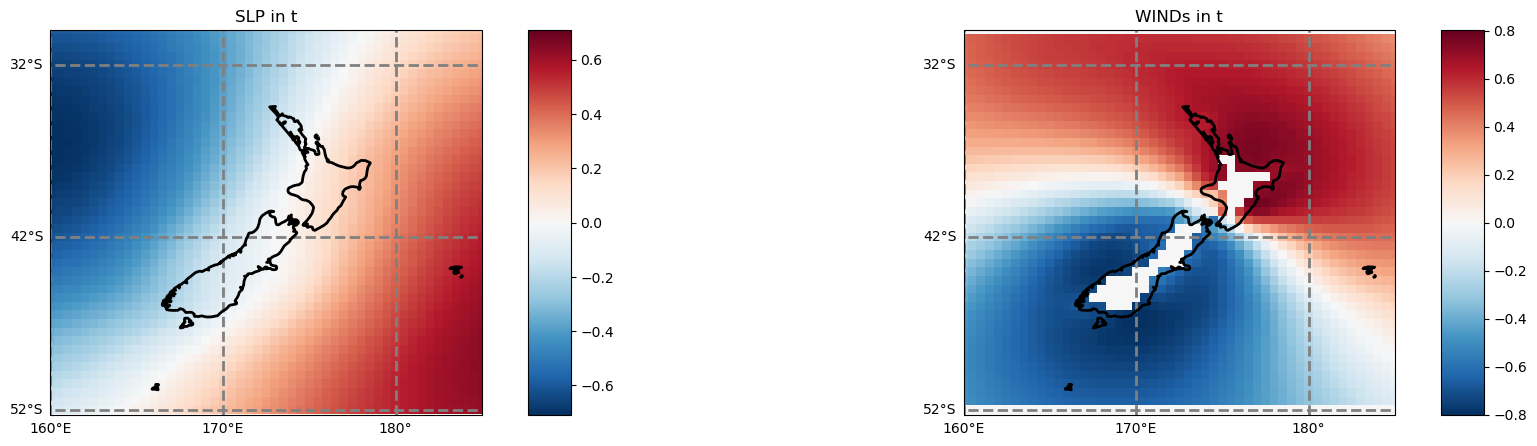

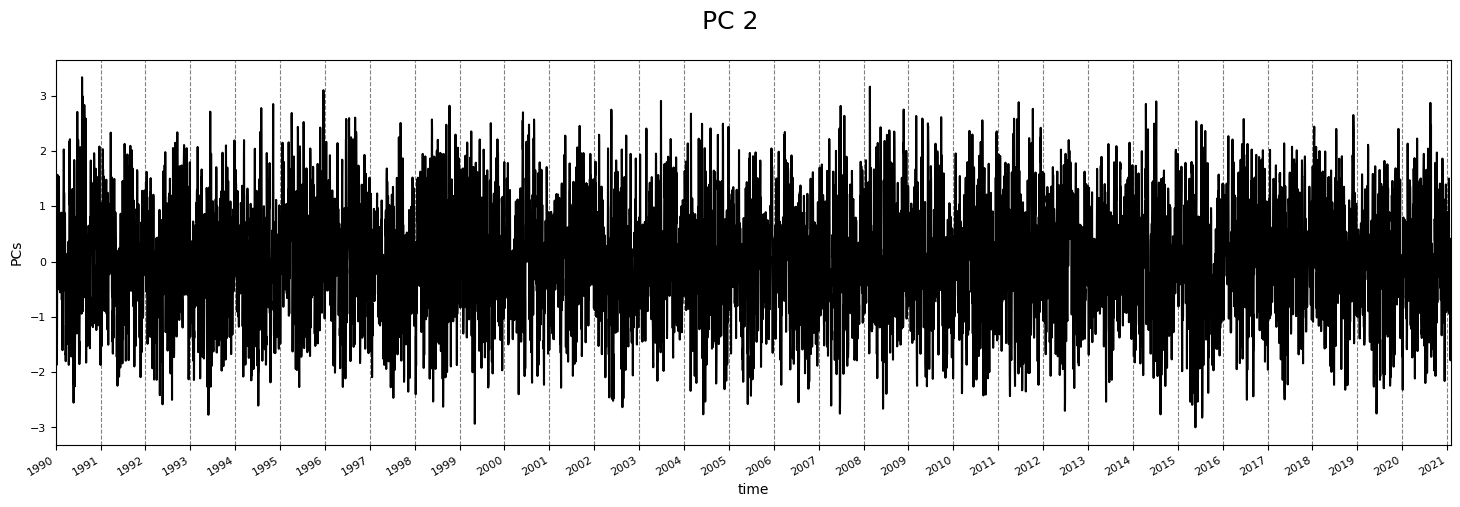


 27 PCs (0.98 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 15 PCs : [ 0  7  5  3  4 16  1 11 22 12 26 14  9 23 25], 
 will be finally used to train the model!! 



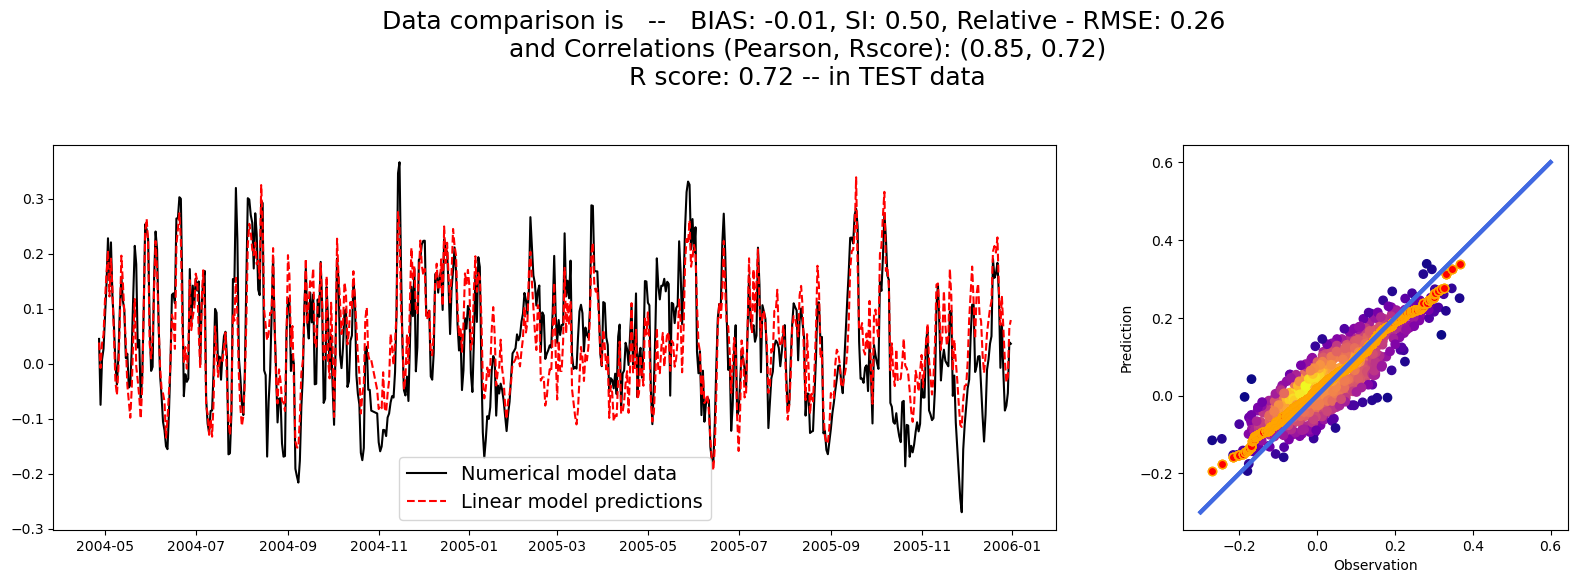

Data comparison is   --   BIAS: -0.01, SI: 0.50, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.85, 0.72)
 R score: 0.72 -- in TEST data


 -- METRICS -- 

 {'bias': -0.009465705945583951, 'si': 0.5000517805585943, 'rmse': 0.0616806789056978, 'rel_rmse': 0.2585474813813902, 'pearson': 0.8518130527627399, 'rscore': 0.7185889320321526, 'ext_rmse': 0.06163475794740895, 'ext_pearson': 0.517348486891456} 

 obtained with LinearRegression(normalize=True) !!


In [12]:
stats_kapiti_wind, lm_kapiti_wind, pcs_to_use_kapiti_wind = MultiLinear_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=False, # no gradient will be used
        winds=(True,kapiti_wind),time_lapse=1,
        wind_vars=('wind_proj_mask','lon','lat'),
        region=(True,default_region_reduced),
        pca_ttls=['SLP in t','WINDs in t'],
        pca_plot=(True,False,2)
    )[0], ss_kapiti, plot_results=True, verbose=True,
    percentage_PCs=0.98 # add more pcs to "local" predictor
)
print(f'\n\n -- METRICS -- \n\n {stats_kapiti_wind} \n\n obtained with {lm_kapiti_wind} !!')


 loading and plotting the private tidal guages... 


 389 PCs (0.95 expl. variance) will be used to train the model!! 


 A forward selection will be performed... 

 where 85 PCs : [  1   6   3   7  21   8 157  11   2 243  15 104 177   4  64  50 372  44
  25 250 264 155 330  97  76 195 190 166  98 262 329  89  75 133 333 216
 383 352   0 240 257 181  86  37  46 103  13 164 237 107 300 182 261 290
 188 228 142  49 350  22 184  23  43  67 385 172   9   5 289 354  34  14
 119 381 296  24 251  56 110 139  77 126 159 310 382], 
 will be finally used to train the model!! 



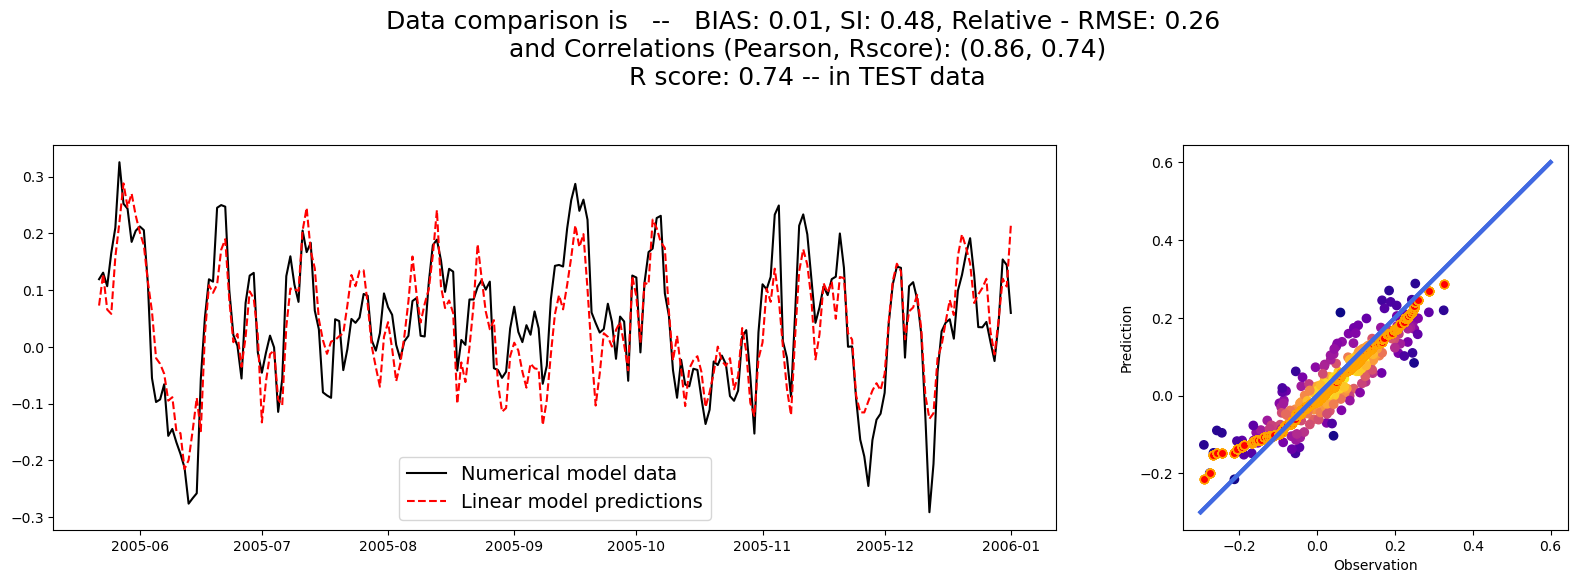

Data comparison is   --   BIAS: 0.01, SI: 0.48, Relative - RMSE: 0.26
 and Correlations (Pearson, Rscore): (0.86, 0.74)
 R score: 0.74 -- in TEST data


 -- METRICS -- 

 {'bias': 0.007103417256921059, 'si': 0.47516180304888306, 'rmse': 0.059786497008495455, 'rel_rmse': 0.2563330640859541, 'pearson': 0.8612725345223137, 'rscore': 0.7379162229146259, 'ext_rmse': 0.07847892381768025, 'ext_pearson': 0.22596860462826726} 

 obtained with LinearRegression(normalize=True) !!


In [13]:
# linear regression in green island
ss_green = load_private_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_green, lm_green, pcs_to_use_green = MultiLinear_Regression(
    pcs_cfsr, ss_green, plot_results=True, verbose=True
)
print(f'\n\n -- METRICS -- \n\n {stats_green} \n\n obtained with {lm_green} !!')

## Linear regression with local predictor

In the following cell, a multilinear regression is performed over all the domain of the Moana v2 hindcast nearshore, having the local pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_lm_local_daily.nc`. Notice that, with the regional predictor, which involves an area of 4 $\cdot$ 4 degrees, we are able to cover just a smaller area, but centered at the location of the virtual moana node.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results, as it could be seen with the regional predictor
```

In [14]:
run = False
if run:
    # perform the Multilinear-Regression (local)
    metrics_local = [] # save local metrics
    pcs_to_use_local = [] # save used pcs 
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    ) # select here the desired sites to apply linreg
    # perform the MultiLinear regression over all the sites
    for stat in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        metrics, model, pcs_to_use = MultiLinear_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True,ctime_lapse=3,
                region=(True, (
                    ss_moana.lon.values[0]-2.2,
                    ss_moana.lon.values[0]+2.2,
                    ss_moana.lat.values[0]+2.2,
                    ss_moana.lat.values[0]-2.2
                )),
                pca_plot=(False,False,2), verbose=False
            )[0],
            ss_moana, percentage_PCs=0.999, plot_results=False, verbose=False
        ) # using the local-pre-loaded pcs
        metrics_local.append(list(metrics.values())) # save site metrics
        pcs_to_use_local.append(pcs_to_use) # save used pcs
    # now, save all in xarray.Dataset
    sites_metrics_local = {}
    for im,metric in enumerate(metrics.keys()):
        sites_metrics_local[metric] = (('station'),np.array(metrics_local)[:,im])
    sites_metrics_local['latitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat.values
    )
    sites_metrics_local['longitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon.values
    )
    # save the metrics
    metrics_dataset_local = xr.Dataset(
        sites_metrics_local,coords={'station':sites_local}
    )
    # local copys
    if False:
        metrics_dataset_local.to_netcdf(
            data_path+'/statistics/models/stats_lm_local_daily_new.nc'
        ) # save metrics in all the stations
        np.save(
            data_path+'/statistics/models/pcs_lm_local_daily_new.npy',
            np.array(pcs_to_use_local)
        ) # save pcs used in the linear regressions
else:
    metrics_dataset_local = xr.open_dataset(
        data_path+'/statistics/models/stats_lm_local_daily.nc'
    )

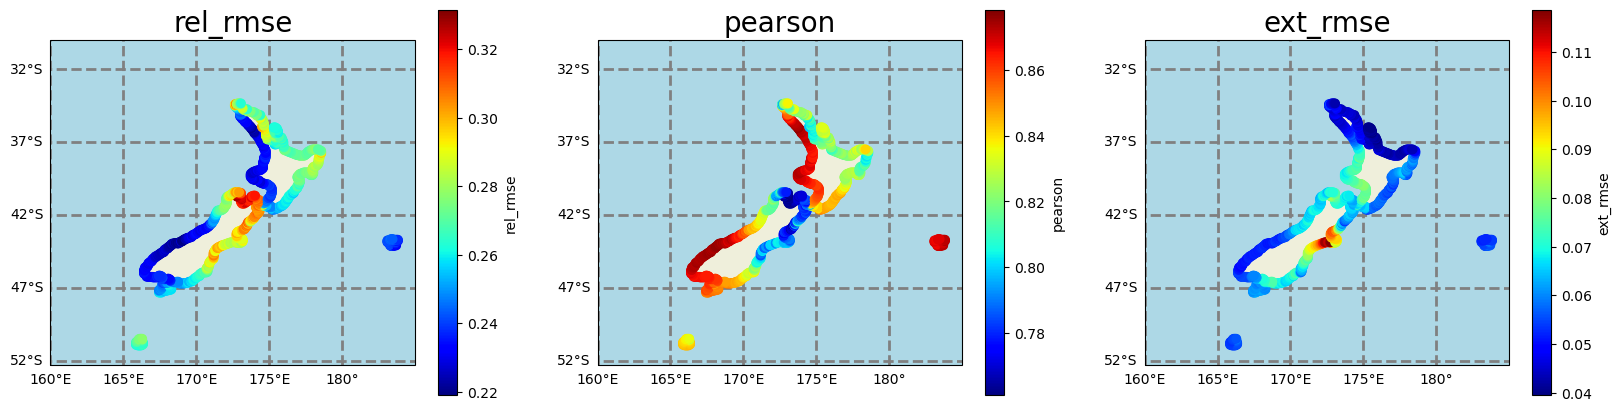

In [15]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(metrics_dataset_local,plot_stats=['rel_rmse','pearson','ext_rmse'])

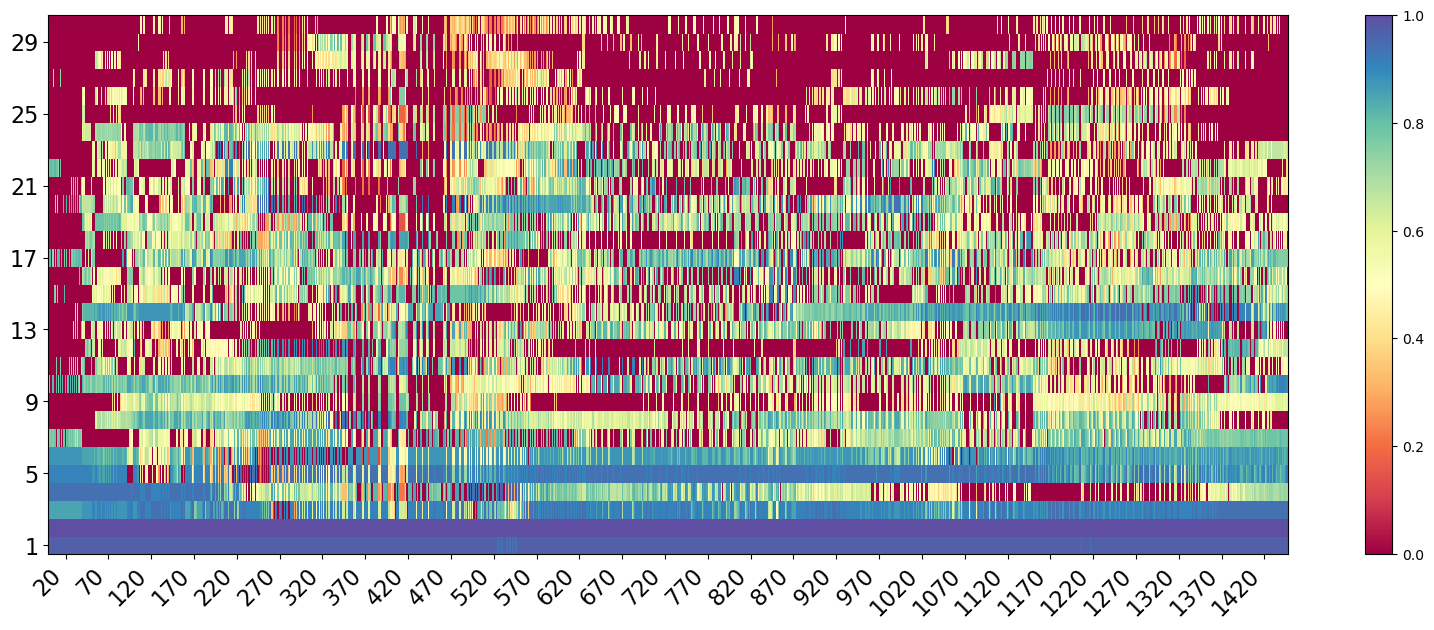

In [16]:
pcs_to_use_local = np.load(
    data_path+'/statistics/models/pcs_lm_local_daily.npy',
    allow_pickle=True
)
max_pcs = max([np.max(array) for array in pcs_to_use_local])
pcs_importance = np.zeros((len(pcs_to_use_local),max_pcs))
for i,array in enumerate(pcs_to_use_local):
    for pc in range(max_pcs):
        try:
            pcs_importance[i,pc] = (max_pcs-np.where(array==pc)[0])/max_pcs
        except:
            continue
fig, ax = plt.subplots(figsize=(20,7))
pcol = ax.pcolor(pcs_importance.T[:30,:],cmap='Spectral')
fig.colorbar(pcol)
ax.set_yticks(np.arange(0,30,4)+0.5)
ax.set_yticklabels(np.arange(0,30,4)+1,fontsize=16)
ax.set_xticks(np.arange(20,len(pcs_to_use_regional))[::50]+0.5)
ax.set_xticklabels(np.arange(
    20,len(load_cfsr_moana_uhslc.predictand.site.values),1
)[::50],fontsize=16)
plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
plt.show()